# Prediction of creditworthiness

## Data description

You are given anonymized data from customers who have already obtained credit cards and are regularly pay their installments. The data are available in a CSV ﬁle [credit_scoring.csv](https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_scoring.csv) that contains the information of account holders who have applied for a line of credit.

- ID: customer identiﬁcation number
- CODE_GENDER: gender of the client
- FLAGOWNCAR: indicator of car ownership
- FLAGOWNREALTY: indicator of a house ownership 
- CNT_CHILDREN: number of children
- AMTINCOMETOTAL: total annual income
- NAMEINCOMETYPE: income type
- NAMEEDUCATIONTYPE: education level
- NAMEFAMILYSTATUS: civil status
- NAMEHOUSINGTYPE: housing type
- DAYS_BIRTH: number of days elapsed since birth
- DAYS_EMPLOYED: number of days since date of employment (if positive, indicate the number of days since unemployed)
- FLAG_MOBIL: indicator of the existence of a mobile phone number
- FLAGWORKPHONE: indicator of the existence of a job phone number
- FLAG_PHONE: indicator of the existence of a phone number
- FLAG_EMAIL: indicator of the existence of a e-mail
- OCCUPATION_TYPE: occupation type
- CNTFAMMEMBERS: number of family members
- TARGET: variable that is 1 if the customer has high creditworthness (constant payment of installments), 0 otherwise.

## Goal

You have to make a model that predicts the given target, which is the TARGET variable that indicates whether the
customer has a good creditworthiness.
If a customer is denied a credit card, the team must be able to provide a reason for it. This means that the model must provide easily interpretable directions.

# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as stats
import itertools
from collections import Counter
import time

#preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.base import BaseEstimator, TransformerMixin



#models
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier

#metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, classification_report

# imblearn import
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# exaplinability
import shap


c:\Users\Tia\Desktop\ProfessionAI\Progetti\Credit_scoring_project\credit_score_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Functions

In [2]:
def variables_type(df):
    '''
    Input pd.dataframe
    Return a tuple of 2 list (categorical and numerical varaibles)
    '''
    num = []
    cat = []
    for var in df.columns:
        if df[var].dtype==object:
            cat.append(var)
        elif set(df[var].unique()) == set([1,0]):
            cat.append(var)
        else:
            num.append(var)
    return (num, cat)

In [3]:
def sub_boxplots(df, var=None, subplot_cols=3, subplot_rows=None, fig_size=(15,10), hue=None, color_box='b'):
    '''
    Print boxplots in subplot setting
    If hue is given as a categorical feature, the boxplot is showed according to that division
    '''
    if var is None:
        var = df.columns
    if subplot_rows is None:
        subplot_rows = math.ceil(len(var)/subplot_cols)
    
    fig, axes = plt.subplots(subplot_rows, subplot_cols, figsize=fig_size)
    axes = axes.flatten()

    params = {}
    if hue is None:
        params['color'] = color_box
        
    for i, col in enumerate(var):
        sns.boxplot(data = df, x=col, ax=axes[i], hue=hue, orient="h", **params)
        
    plt.show()


In [4]:
def proportion_figure(fig_size, ncols, nrows):
    '''
    Re-calibrate the proportion of the figure size
    '''
    total_area = math.prod(fig_size)
    subplot_ratio = ncols / nrows
    fig_width = (total_area * subplot_ratio) ** 0.5
    fig_height = fig_width / subplot_ratio
    return (fig_width, fig_height)

In [5]:
def plot_features_distribution(df, subplot_cols=3, fig_size=(15,10), boxplot=False, color_bar='blue'):
    '''
    Take in input a df and the subplot cols
    Differentiate from categorical to numerical variables
    Plot the distribution of the features in the df
    Show the mean, the median and the skewness of the distribution
    If boxplot set True show the boxplots for num var
    '''
    num_var, cat_var = variables_type(df)
    
    # numerical var distribution subplot
    subplot_num_rows = math.ceil(len(num_var)/subplot_cols)
    fig_num, axes = plt.subplots(subplot_num_rows, subplot_cols, figsize=fig_size)
    axes = axes.flatten()

    for i, col in enumerate(num_var):
        axes[i].hist(df[col], color=color_bar, bins="rice", edgecolor ='black' ,alpha=0.7)
        axes[i].axvline(df[col].mean(), color='red', linestyle='-')
        axes[i].axvline(df[col].median(), color='g', linestyle='-')
        axes[i].set_title(col)
        skw = df[col].skew()
        axes[i].legend(['mean', 'median', 'skewness: {:.2f}'.format(skw)], loc='upper right')
        
    plt.show()
    
    # show boxplot of numerical variables
    if boxplot:
        sub_boxplots(df, var=num_var, subplot_cols=subplot_cols, color_box=color_bar, fig_size=fig_size)

    # categorical var histogram
    subplot_cat_rows = math.ceil(len(cat_var)/subplot_cols)
    fig_size = proportion_figure(fig_size, subplot_cols, subplot_cat_rows)    #create new proportions
    
    fig_cat, axes = plt.subplots(subplot_cat_rows, subplot_cols, figsize=fig_size)
    axes = axes.flatten()

    for i, col in enumerate(cat_var):
        unique_values = df[col].unique()
        
        if len(unique_values)>2:    # for long labels
            counts = df[col].value_counts()
            positions = np.arange(len(counts))
            values = counts.values
            labels = counts.index.astype(str)
            axes[i].bar(positions, values, color=color_bar, edgecolor='black')
            offset = max(values)*0.05
            for pos, label, val in zip(positions, labels, values):
                axes[i].text(pos,  offset ,          
                        label,
                        ha='center',     
                        va='baseline',             
                        rotation=90,
                        color='black',
                        fontsize=8)
            axes[i].tick_params(axis='x', bottom=False, labelbottom=False)

        else:    # for short labels
            bins = np.arange(len(unique_values) + 1) - 0.5  
            axes[i].hist(df[col], bins=bins, color=color_bar, 
                        edgecolor ='black' ,alpha=0.7, histtype='bar', rwidth=0.6,  align='mid')
            axes[i].set_xticks(unique_values)
            axes[i].set_xticklabels(unique_values)
            
        axes[i].set_title(col)
        
    plt.show()

In [6]:
def count_outliers(series):
    Q1, Q3 = series.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    return ((series < (Q1 - 1.5 * IQR)) | (series > (Q3 + 1.5 * IQR))).sum()

In [7]:
def cramers_v(x, y):
    '''
    Function calculates the Cramer's V index from Chi2 value
    Effect size of comparison (association) between 2 categorical variable
    '''
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))

def cramers_matrix(df):
    '''
    Creation of the correlation matrix with cramers values
    Input df with only categorical variables
    '''
    cols = df.columns
    matrix = pd.DataFrame(np.eye(len(cols)), index=cols, columns=cols)

    for col1, col2 in itertools.combinations(cols, 2):
        cramers_value = cramers_v(df[col1], df[col2])
        matrix.loc[col1, col2] = cramers_value
        matrix.loc[col2, col1] = cramers_value  
    return matrix

In [8]:
def h_squared_kw(cat, num):
    '''
    Computing the effect size of the Kruskal-Wallis test,
    Returns the H statistic normalized (eta-squared of KW test) 
    '''
    groups = [num[cat == level] for level in np.unique(cat)]
    h_stat, p_value = stats.kruskal(*groups)  
    n = len(num)
    h_squared = (h_stat / (n - 1)) if n > 1 else 0  
    return h_squared


In [9]:
def eta_squared_anova(cat, num):
    '''
    Computing the effect size of the one-way ANOVA test,
    Returns the eta-squared statistic  
    '''
    groups = [num[cat == level] for level in np.unique(cat)]
    f_stat, p_value = stats.f_oneway(*groups) 
    ss_between = sum(len(group) * (group.mean() - num.mean()) ** 2 for group in groups)
    ss_total = sum((num - num.mean()) ** 2)
    eta_squared = ss_between / ss_total if ss_total > 0 else 0
    return eta_squared

In [10]:
def eta2_matrix(df, test='KW'):
    '''
    Input df with both variables (cat, num)
    Return the eta-squared value of the test
    test='ANOVA' if the numerical variables have normal distributions
    test='KW' if the test performed is the non-parametric Kruskal-Wallis (default)
    '''
    num_var, cat_var = variables_type(df)
    correlation_matrix = pd.DataFrame(index=cat_var, columns=num_var)

    if test == 'KW':
        for cat_col in cat_var:
            for num_col in num_var:
                correlation_matrix.loc[cat_col, num_col] = h_squared_kw(df[cat_col], df[num_col])
    elif test == 'ANOVA':
        for cat_col in cat_var:
            for num_col in num_var:
                correlation_matrix.loc[cat_col, num_col] = eta_squared_anova(df[cat_col], df[num_col])

    correlation_matrix = correlation_matrix.astype(float)
    return correlation_matrix

In [11]:
def heat_map(df, method, figsize=(10, 8), test='KW', diagonal=False):
    '''
    Plot an heatmap
    pd.DataFrame in input
    method = "num" return correlation between numerical variables with Pearson Correlation Index,
    method = "cat" return the intensity of the association between categorical variables with Cramer's V Index,
    method = "both" return the effect size of one-way ANOVA test (or Kruskal-Wallis) between cat e num variables with the eta-squared values
    test indicates if performed Kruskal-Wallis (KW) or ANOVA
    diagonal=True shows only the lower triangle (default False)
    '''
    if method == "num":
        corr_matrix = df.corr()
        title_text = "Pearson correlation for numerical variables"
    elif method == "cat":
        corr_matrix = cramers_matrix(df)
        title_text = "Cramer's V index for categorical variables"
    elif method == "both":
        corr_matrix = eta2_matrix(df, test=test)
        title_text = "Eta-squared for numerical-categorical variables relations"

    if diagonal:
        # generate a mask for the upper triangle
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    else:
        mask=None
        
    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, annot=True, mask=mask, fmt=".2f")
    plt.title(title_text)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)  
    plt.show()

In [12]:
def sub_stacked_hist(df, var=None, subplot_cols=3, subplot_rows=None, fig_size=(15,10), hue='target'):
    '''
    Plot staked hisrograms in suplot setting for the variables of a df
    hue is the variable on which the plotted feature is divided by color (defaul 'target') 
    '''
    if var is None:
        var = df.columns
    if subplot_rows is None:
        subplot_rows = math.ceil(len(var)/subplot_cols)
    
    fig_size = proportion_figure(fig_size, subplot_cols, subplot_rows)
    fig, axes = plt.subplots(subplot_rows, subplot_cols, figsize=fig_size)
    axes = axes.flatten()

    for i, col in enumerate(var):
        sns.histplot(data = df,x = col, ax=axes[i], hue=hue, multiple='stack')
        
    plt.show()

In [13]:
def hp_correlations(x,y,test='chi2', corr_index='pearson', alpha=0.05):
    '''
    Input 2 distributions (x,y are arrays of values) to compare in a hypothesis test
    H_0 : the 2 variables are independent (no correlation/association)
    Return a tuple with p_value and the test results (as dictionaries)
    test = 'chi2' for categorical variables (or num-cat), the variables need to be discrete
    test = 'num' for only numerical variables
    corr_index give the correlation index to use ('pearson' or 'spearman')    
    '''
    res=[]
    if test == 'chi2':
        tab = pd.crosstab(x,y)
        chi2, p_value, _, exp_freq = stats.chi2_contingency(tab)
        res = [{'chi2-stat':chi2}, {'freq-tab':tab}, {'expected-freq':exp_freq}]
    elif test == 'num':
        if corr_index == 'pearson':
            cor, p_value = stats.pearsonr(x, y)
        elif corr_index == 'spearman':
            cor, p_value = stats.spearmanr(x, y)
        res = [{'corr_index':cor}]
    

    if p_value<alpha:
        print(f"P-value: {p_value:.5f} < {alpha:.2f}, H_0 is rejected. The correlation between 2 variables is significantly different to 0.")
    else:
        print(f"P-value: {p_value:.5f} > {alpha:.2f}, H_0 isn't rejected.")

    return (p_value, res)

In [14]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_keep=None):
        self.features_to_keep = features_to_keep

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.features_to_keep is None:
            return X
        return X[self.features_to_keep]

In [15]:
def make_pipeline(name, model,
                  num_features, cat_features, 
                  feature_sel=None,
                  num_trasf=None, cat_trasf=None,
                  resampling=False, strategy=None,
                  random_seed=0):
    '''
    Return a pipeline based on the input received
    model is the classifier
    num_trasf and cat_trasf are the trasformers for numerical and categorical features
    resampling value accepted: 'over', 'under', 'smote', 'cl_weight' (even isn't a resampling method but is to simplify)
    strategy = proportion of the monority class for the resampling step
    '''
    if feature_sel is not None:
        num_features = [f for f in num_features if f in feature_sel]
        cat_features = [f for f in cat_features if f in feature_sel]
        
    steps = []
    steps.append(('feature_selector', FeatureSelector(features_to_keep=feature_sel)))
    preprocessor = ColumnTransformer(transformers=[
        ('num_trasf', num_trasf, num_features),
        ('cat_trasf', cat_trasf, cat_features)
            ])
    steps.append(('preprocessing', preprocessor))
    
    if resampling == 'smote':
        smote = SMOTE(sampling_strategy=strategy, random_state=random_seed)
        steps.append(('smote', smote))
    
    if resampling == 'over':
        random_oversampling = RandomOverSampler(sampling_strategy=strategy, random_state=random_seed)
        steps.append(('oversampling', random_oversampling))
    
    if resampling == 'under':
        random_undersampling = RandomUnderSampler(sampling_strategy=strategy, random_state=random_seed)
        steps.append(('undersampling', random_undersampling))
        
    if resampling == 'cl_weight':
        if name == 'XGB':
            model.set_params(scale_pos_weight= 1/strategy)
        else:
            model.set_params(class_weight={0: 1, 1: 1/strategy})
            
    steps.append((name, model))
    return ImbPipeline(steps=steps)

In [16]:
def get_performance_metrics(y_test, y_pred, y_proba, name_model, resample_name=None, feature_sel=None, label=1, metrics=None):
    '''
    If metrics is given the metrics are automatically saved in the dict
    Otherwise the metrics are calculated inside
    '''
    if metrics:
        result = {
        'Feature Selection' : feature_sel,
        'Resampling': resample_name,
        'Model': name_model,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1 Score': metrics['f1_score'],
        'ROC_AUC': metrics['roc_auc']
        }
        
    else: 
        result = {
            'Feature Selection' : feature_sel,
            'Resampling': resample_name,
            'Model': name_model,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, pos_label=label),
            'Recall': recall_score(y_test, y_pred, pos_label=label),
            'F1 Score': f1_score(y_test, y_pred, pos_label=label),
            'ROC_AUC': roc_auc_score(y_test, y_proba)
            }
        
    return result

In [17]:
def get_best_models_by_metrics(metrics, results_df):
    '''
    Return a DataFrame with the best model (no duplicates) by every metric in metrics
    '''
    best = pd.DataFrame()
    best_output = pd.DataFrame()
    for metric in metrics:
        best = results_df.sort_values(by=metric, ascending=False)
        best_output = pd.concat([best_output, best.iloc[0:1]])
        
    best_output = best_output.drop_duplicates()
    return best_output

In [18]:
def analyze_gap(train, test, threshold_gap, threshold_under):
    gap = train - test
    if train < threshold_under and test < threshold_under:
        return "Underfitting"
    elif gap > threshold_gap:
        return "Overfitting"
    else:
        return "Good generalization"

In [19]:
def LigthGBM_predictor(lgbm_model, num_trasf, cat_trasf, 
                       X_train, X_test, y_train, y_test,
                       num_features, cat_features,
                       feature_sel=None,
                       resampling=False, strategy=None,
                       overfitting_test=False,
                       random_seed=0,
                       mod_name=None):
    resampler = None
    if feature_sel is not None:
        X_train = X_train[feature_sel]
        X_test = X_test[feature_sel]
        num_features = [f for f in num_features if f in feature_sel]
        cat_features = [f for f in cat_features if f in feature_sel]

    preprocessor = ColumnTransformer(transformers=[
        ('num_trasf', num_trasf, num_features),
        ('cat_trasf', cat_trasf, cat_features)
    ])

    # Fit + transform training set
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    # rebuild dataframe with column names
    processed_columns = num_features + cat_features
    X_train_df = pd.DataFrame(X_train_processed, columns=processed_columns, index=X_train.index)
    X_test_df = pd.DataFrame(X_test_processed, columns=processed_columns, index=X_test.index)
    
    # check resampling 
    if resampling == 'smote':
        resampler = SMOTE(sampling_strategy=strategy, random_state=random_seed)
    elif resampling == 'over':
        resampler = RandomOverSampler(sampling_strategy=strategy, random_state=random_seed)
    elif resampling == 'under':
        resampler = RandomUnderSampler(sampling_strategy=strategy, random_state=random_seed)
    elif resampling == 'cl_weight':
        lgbm_model.set_params(class_weight={0: 1, 1: 1/strategy})

    if resampler is not None:
        X_train_resampled, y_train_resampled = resampler.fit_resample(X_train_df, y_train)
        # Convert again to DataFrame for compatibility
        X_train_df = pd.DataFrame(X_train_resampled, columns=processed_columns)
        y_train = y_train_resampled 
  
    # fit the model
    lgbm_model.fit(X_train_df, y_train, categorical_feature=cat_features)

    y_pred = lgbm_model.predict(X_test_df)
    y_proba = lgbm_model.predict_proba(X_test_df)[:,1]
    
    if overfitting_test:
        # process to evaluate over/under fitting
        y_pred_test = y_pred.copy()
        y_proba_test = y_proba.copy()
        y_pred_train = lgbm_model.predict(X_train_df)
        y_proba_train = lgbm_model.predict_proba(X_train_df)[:,1]
        
        train_metrics = {
            'precision': precision_score(y_train, y_pred_train),
            'accuracy': accuracy_score(y_train, y_pred_train),
            'f1_score': f1_score(y_train, y_pred_train),
            'recall': recall_score(y_train, y_pred_train),
            'roc_auc': roc_auc_score(y_train, y_proba_train),
            }
        test_metrics = {
            'precision': precision_score(y_test, y_pred_test),
            'accuracy': accuracy_score(y_test, y_pred_test),
            'f1_score': f1_score(y_test, y_pred_test),
            'recall': recall_score(y_test, y_pred_test),
            'roc_auc': roc_auc_score(y_test, y_proba_test),
            }

        diagnosis = {}

        diagnosis['roc_auc'] = analyze_gap(train_metrics['roc_auc'], test_metrics['roc_auc'], threshold_gap=0.05, threshold_under=0.7)
        diagnosis['precision'] = analyze_gap(train_metrics['precision'], test_metrics['precision'], threshold_gap=0.10, threshold_under=0.6)
        diagnosis['f1_score'] = analyze_gap(train_metrics['f1_score'], test_metrics['f1_score'], threshold_gap=0.08, threshold_under=0.5)
        diagnosis['recall'] = analyze_gap(train_metrics['recall'], test_metrics['recall'], threshold_gap=0.10, threshold_under=0.5)
        diagnosis['accuracy'] = analyze_gap(train_metrics['accuracy'], test_metrics['accuracy'], threshold_gap=0.05, threshold_under=0.6)

        print(f"{mod_name} evaluation:")
        for metric, evaluation in diagnosis.items():
            print(f"\t{metric.upper()}: {evaluation}")
        
        return (train_metrics, test_metrics)
        
    return (y_pred, y_proba)

In [20]:
def get_feature_names_from_column_transformer(ct):
    output_features = []

    for name, transformer, cols in ct.transformers_:
        if transformer == 'drop':
            continue
        elif transformer == 'passthrough':
            output_features.extend(cols)
        else:
            try:
                names = transformer.get_feature_names_out(cols)
            except AttributeError:
                names = [f"{name}__{col}" for col in cols]
            output_features.extend(names)

    return output_features

In [21]:
def get_resampling_method(df):
    '''
    Input df 
    Select the resampling from the column "Resampling", formatted as string
    Return a list of tuples
    Tuple of resampling method and resampling ratio
    '''
    output_list=[]
    res_string = df['Resampling']
    for i in res_string:
        method, ratio = i.split()
        ratio = float(ratio)
        output_list.append((method, ratio))
        
    return output_list


In [22]:
def evaluate_overfitting_underfitting(pipeline, X_train, y_train, X_test, y_test, mod_name=None):
    '''
    Calcualte the metrics accuracy, f1-score, precision, recall, roc_auc
    Print the evaluation on over/under fitting 
    Return a tuple with train_metrics and test_metrics dictionaries
    '''
    pipeline.fit(X_train, y_train)
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    try:
        y_proba_train = pipeline.predict_proba(X_train)[:, 1]
        y_proba_test = pipeline.predict_proba(X_test)[:, 1]
        roc_auc_train = roc_auc_score(y_train, y_proba_train)
        roc_auc_test = roc_auc_score(y_test, y_proba_test)
    except:
        roc_auc_train = None
        roc_auc_test = None
        
    train_metrics = {
        'accuracy': accuracy_score(y_train, y_pred_train),
        'precision': precision_score(y_train, y_pred_train),
        'recall': recall_score(y_train, y_pred_train),
        'f1_score': f1_score(y_train, y_pred_train),
        'roc_auc': roc_auc_train,
        }
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_pred_test),
        'precision': precision_score(y_test, y_pred_test),
        'recall': recall_score(y_test, y_pred_test),
        'f1_score': f1_score(y_test, y_pred_test),
        'roc_auc': roc_auc_test,
        }

    diagnosis = {}

    diagnosis['roc_auc'] = analyze_gap(train_metrics['roc_auc'], test_metrics['roc_auc'], threshold_gap=0.05, threshold_under=0.7)
    diagnosis['precision'] = analyze_gap(train_metrics['precision'], test_metrics['precision'], threshold_gap=0.10, threshold_under=0.6)
    diagnosis['f1_score'] = analyze_gap(train_metrics['f1_score'], test_metrics['f1_score'], threshold_gap=0.08, threshold_under=0.5)
    diagnosis['recall'] = analyze_gap(train_metrics['recall'], test_metrics['recall'], threshold_gap=0.10, threshold_under=0.5)
    diagnosis['accuracy'] = analyze_gap(train_metrics['accuracy'], test_metrics['accuracy'], threshold_gap=0.05, threshold_under=0.6)

    # print results
    print(f'{mod_name} evaluation:')
    for metric, evaluation in diagnosis.items():
        print(f"\t{metric.upper()}: {evaluation}")

    return (train_metrics, test_metrics)

In [23]:
def get_mod_params(name, rf_params, xgb_params, lightgbm_params):
    params=[]
    if name == 'RF':
        params = rf_params
    elif name == 'XGB':
        params = xgb_params
    elif name == 'LightGBM':
        params = lightgbm_params
        
    return params

# Load dataset

In [24]:
url = "https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_scoring.csv"
file = "credit_scoring.csv"

In [ ]:
df = pd.read_csv(url)

# EDA
## Overview

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338427 entries, 0 to 338426
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   338427 non-null  int64  
 1   CODE_GENDER          338427 non-null  object 
 2   FLAG_OWN_CAR         338427 non-null  object 
 3   FLAG_OWN_REALTY      338427 non-null  object 
 4   CNT_CHILDREN         338427 non-null  int64  
 5   AMT_INCOME_TOTAL     338427 non-null  float64
 6   NAME_INCOME_TYPE     338427 non-null  object 
 7   NAME_EDUCATION_TYPE  338427 non-null  object 
 8   NAME_FAMILY_STATUS   338426 non-null  object 
 9   NAME_HOUSING_TYPE    338426 non-null  object 
 10  DAYS_BIRTH           338426 non-null  float64
 11  DAYS_EMPLOYED        338426 non-null  float64
 12  FLAG_MOBIL           338426 non-null  float64
 13  FLAG_WORK_PHONE      338426 non-null  float64
 14  FLAG_PHONE           338426 non-null  float64
 15  FLAG_EMAIL       

In [27]:
df.shape

(338427, 19)

In [28]:
len(df['ID'].unique())

338427

There are 338427 IDs as many as the records of the dataset, this means no information for us. 

This feature can be deleted.

In [29]:
df.drop(['ID'], axis=1, inplace=True)

In [30]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CNT_CHILDREN,338427.0,0.428934,0.727990,0.00,0.00,0.00,1.000,19.00
AMT_INCOME_TOTAL,338427.0,187668.547635,110786.279376,25548.98,121229.95,162855.26,225208.155,7071015.83
DAYS_BIRTH,338426.0,-15998.212897,4193.088539,-26636.00,-19467.00,-15623.00,-12516.250,-7566.00
DAYS_EMPLOYED,338426.0,60234.533869,138522.923248,-17973.00,-3116.00,-1483.00,-378.000,396498.00
FLAG_MOBIL,338426.0,1.000000,0.000000,1.00,1.00,1.00,1.000,1.00
FLAG_WORK_PHONE,338426.0,0.211379,0.408287,0.00,0.00,0.00,0.000,1.00
FLAG_PHONE,338426.0,0.293302,0.455276,0.00,0.00,0.00,1.000,1.00
FLAG_EMAIL,338426.0,0.105181,0.306787,0.00,0.00,0.00,0.000,1.00
CNT_FAM_MEMBERS,338426.0,2.197228,0.899570,1.00,2.00,2.00,3.000,20.00
TARGET,338427.0,0.087824,0.283039,0.00,0.00,0.00,0.000,1.00


In [31]:
df.isna().sum()

CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          1
NAME_HOUSING_TYPE           1
DAYS_BIRTH                  1
DAYS_EMPLOYED               1
FLAG_MOBIL                  1
FLAG_WORK_PHONE             1
FLAG_PHONE                  1
FLAG_EMAIL                  1
OCCUPATION_TYPE        103342
CNT_FAM_MEMBERS             1
TARGET                      0
dtype: int64

There are some features showing only one missing values, this seems a strange behavior to check.

In [32]:
index_nan = df.loc[df['DAYS_BIRTH'].isna()].index
df.loc[index_nan]

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
338426,F,N,N,0,68765.48,Working,Secondary / se,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [33]:
df_check = df.drop(index_nan, axis=0)
df_check.isna().sum()

CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        103341
CNT_FAM_MEMBERS             0
TARGET                      0
dtype: int64

There was a problem in that record so we can delete it.

In [34]:
df.drop(index_nan, inplace=True)

In [35]:
df.shape

(338426, 18)

For feature *OCCUPATION_TYPE* we have 103342, so we have to handle those missing values.

In [36]:
num, cat = variables_type(df)

In [37]:
num

['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'FLAG_MOBIL',
 'CNT_FAM_MEMBERS']

*FLAG_MOBIL* should be a dummy variable, so we check it

In [38]:
print(f"Unique values in FLAG_MOBIL feature: {df['FLAG_MOBIL'].unique()}")
print(f"Lines with values = 1 : {len(df.loc[df['FLAG_MOBIL']==1])}")

Unique values in FLAG_MOBIL feature: [1.]
Lines with values = 1 : 338426


Having all the rows in the feature *FLAG_MOBIL* with value 1 does not give us information so we can delete it.

In [39]:
df.drop(['FLAG_MOBIL'], axis=1, inplace=True)

In [40]:
df.shape

(338426, 17)

Changing the nan (float type) value with the string 'Nan' so it's easier to manage those values in the counts.

In [41]:
df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].fillna('Missing')

In [42]:
num, cat = variables_type(df)

In [43]:
num

['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'CNT_FAM_MEMBERS']

In [44]:
cat

['CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'TARGET']

## Univariate Analysis

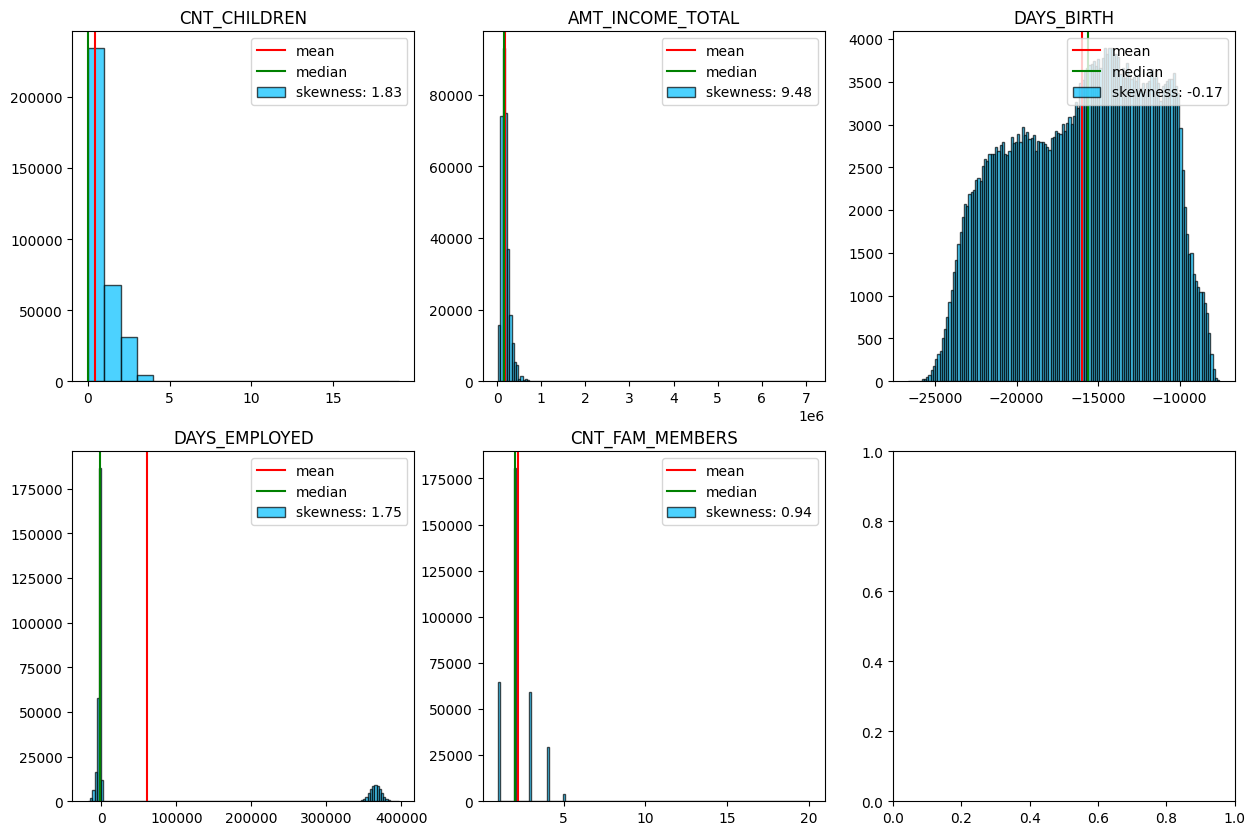

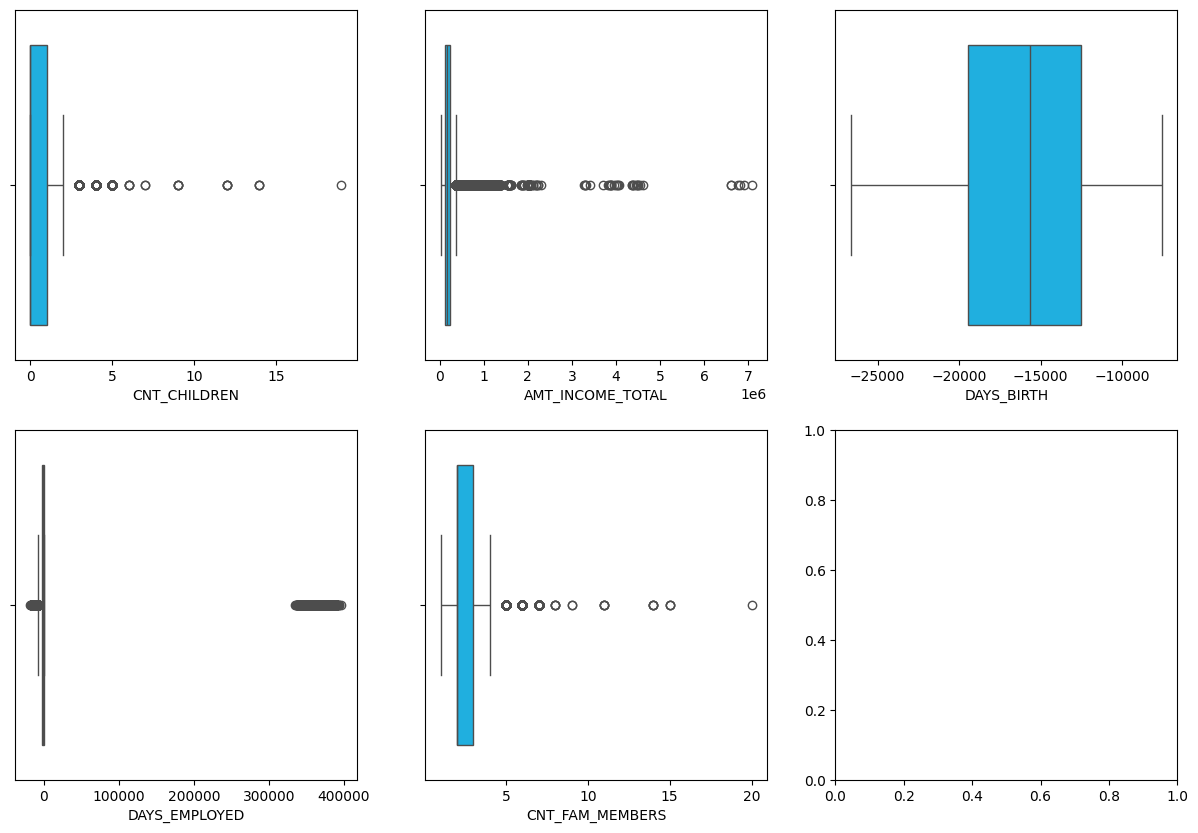

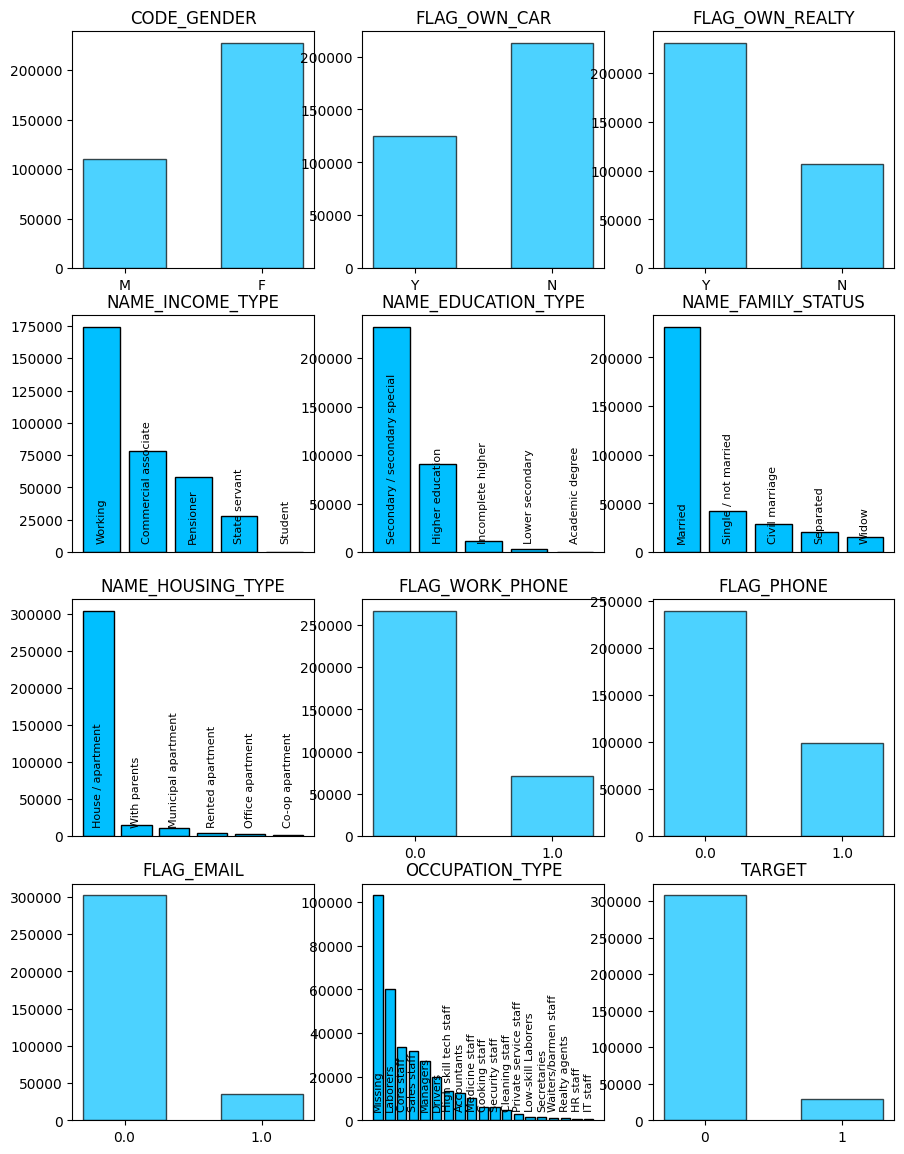

In [45]:
plot_features_distribution(df, subplot_cols=3, boxplot=True, fig_size=(15,10), color_bar='deepskyblue')

In [46]:
for var in num:
    outlier_count = count_outliers(df[var])
    print(f"Counting outlier of {var}: {outlier_count}, {round(outlier_count/len(df), 2)}%")

Counting outlier of CNT_CHILDREN: 4757, 0.01%
Counting outlier of AMT_INCOME_TOTAL: 14027, 0.04%
Counting outlier of DAYS_BIRTH: 0, 0.0%
Counting outlier of DAYS_EMPLOYED: 74765, 0.22%
Counting outlier of CNT_FAM_MEMBERS: 4440, 0.01%


### Analysis of *DAYS_EMPLOYED* 

This variable has a strange distribution and a very high number of outliers (22%).

From the whole distribution we can recognize 2 separate distributions.

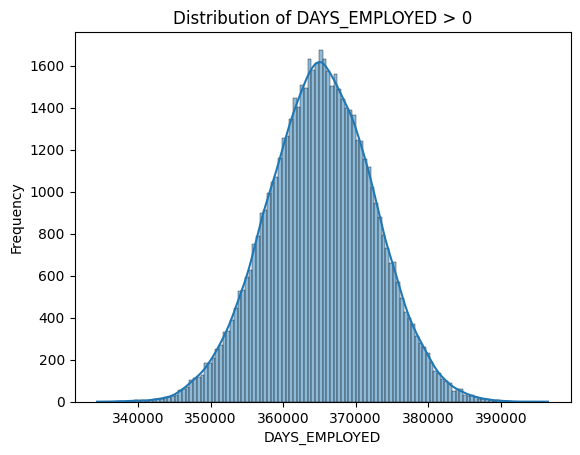

Count values over 0 = 57841


In [47]:
filtered = df[df['DAYS_EMPLOYED'] > 0]
sns.histplot(filtered['DAYS_EMPLOYED'], kde=True)
plt.title(f"Distribution of DAYS_EMPLOYED > 0")
plt.xlabel('DAYS_EMPLOYED')
plt.ylabel('Frequency')
plt.show()
print(f"Count values over 0 = {filtered['DAYS_EMPLOYED'].count()}")

In [48]:
filtered['DAYS_EMPLOYED'].describe().transpose()

count     57841.000000
mean     365218.390052
std        7328.552325
min      334364.000000
25%      360291.000000
50%      365234.000000
75%      370199.000000
max      396498.000000
Name: DAYS_EMPLOYED, dtype: float64

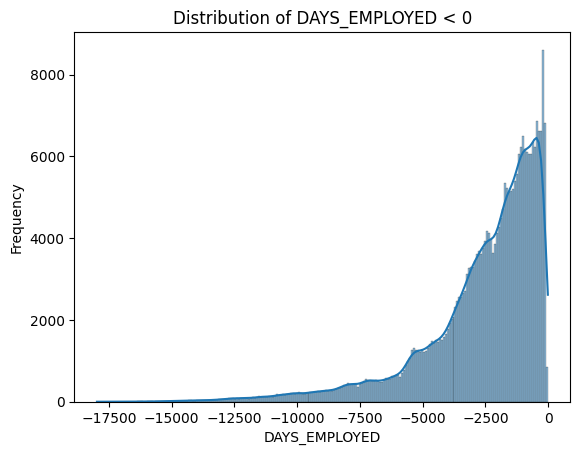

Count values under 0 = 280585


In [49]:
filtered = df[df['DAYS_EMPLOYED'] < 0]
sns.histplot(filtered['DAYS_EMPLOYED'], kde=True)
plt.title(f"Distribution of DAYS_EMPLOYED < 0")
plt.xlabel('DAYS_EMPLOYED')
plt.ylabel('Frequency')
plt.show()
print(f"Count values under 0 = {filtered['DAYS_EMPLOYED'].count()}")

In [50]:
filtered['DAYS_EMPLOYED'].describe().transpose()

count    280585.000000
mean      -2636.151398
std        2411.251906
min      -17973.000000
25%       -3522.000000
50%       -1946.000000
75%        -922.000000
max         -12.000000
Name: DAYS_EMPLOYED, dtype: float64

🔔 *DAYS_EMPLOYED* insight

The 2 histograms show that the values over 0 are anomalies (because nobody is unemployed by $ 365218/365 \approx 1000 $ years). Those values are labeled as Nan and a flag is created to record the anomalies.

The Nan values are imputed with the median (because the distribution is very skewed).

In [51]:
df['DAYS_EMPLOYED_ANOM'] = (df['DAYS_EMPLOYED'] > 0).astype(int)
df.loc[df['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'] = np.nan
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].fillna(df['DAYS_EMPLOYED'].median())


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338426 entries, 0 to 338425
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   CODE_GENDER          338426 non-null  object 
 1   FLAG_OWN_CAR         338426 non-null  object 
 2   FLAG_OWN_REALTY      338426 non-null  object 
 3   CNT_CHILDREN         338426 non-null  int64  
 4   AMT_INCOME_TOTAL     338426 non-null  float64
 5   NAME_INCOME_TYPE     338426 non-null  object 
 6   NAME_EDUCATION_TYPE  338426 non-null  object 
 7   NAME_FAMILY_STATUS   338426 non-null  object 
 8   NAME_HOUSING_TYPE    338426 non-null  object 
 9   DAYS_BIRTH           338426 non-null  float64
 10  DAYS_EMPLOYED        338426 non-null  float64
 11  FLAG_WORK_PHONE      338426 non-null  float64
 12  FLAG_PHONE           338426 non-null  float64
 13  FLAG_EMAIL           338426 non-null  float64
 14  OCCUPATION_TYPE      338426 non-null  object 
 15  CNT_FAM_MEMBERS  

### Distribution values

In [53]:
num, cat = variables_type(df)

In [54]:
df_num = df.drop(columns=cat)
df_cat = df.drop(columns=num)

In [55]:
df_num.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CNT_CHILDREN,338426.0,0.428936,0.727991,0.00,0.000,0.000,1.0000,19.00
AMT_INCOME_TOTAL,338426.0,187668.898976,110786.254513,25548.98,121230.575,162855.645,225208.1675,7071015.83
DAYS_BIRTH,338426.0,-15998.212897,4193.088539,-26636.00,-19467.000,-15623.000,-12516.2500,-7566.00
DAYS_EMPLOYED,338426.0,-2518.196374,2210.864535,-17973.00,-3116.000,-1946.000,-1101.0000,-12.00
CNT_FAM_MEMBERS,338426.0,2.197228,0.899570,1.00,2.000,2.000,3.0000,20.00


In [56]:
df_cat_summary = (df_cat.melt(id_vars=[], value_vars=cat, var_name="Variable", value_name="Values")
                .groupby(["Variable", "Values"])
                .size()
                .reset_index(name="Counting")
                .sort_values(by=['Variable', 'Counting'], ascending=[True, False]))

display(df_cat_summary)

,Variable,Values,Counting
0,CODE_GENDER,F,227915
1,CODE_GENDER,M,110511
2,DAYS_EMPLOYED_ANOM,0.0,280585
3,DAYS_EMPLOYED_ANOM,1.0,57841
4,FLAG_EMAIL,0.0,302830
5,FLAG_EMAIL,1.0,35596
6,FLAG_OWN_CAR,N,213195
7,FLAG_OWN_CAR,Y,125231
9,FLAG_OWN_REALTY,Y,231307
8,FLAG_OWN_REALTY,N,107119


🔔 Distributions insight

Numerical variable distributions: 
- *DAYS__BIRTH* si the most gaussian like distribution with almost zero skewness and no outliers,
- all the other numerical variables show outliers in the upper limit of the range of values (22% of outliers for *DAYS_EMPLOYED*).
 

Categorical variables distributions:
- In *INCOME_TYPE* (working), *FAMILY_STATUS* (married), *OCCUPATION_TYPE* (laborers), *HOUSING_TYPE* (house / apartement), *EDUCATION_TYPE* (secondary) we see a category much more frequent than all the others
- for *OCCUPATION_TYPE* we need to manage the high number of Nan (named 'Missing') values (103341).

The dataset is highly imbalanced on the *TARGET* variable, should be managed with appropriate methods (resampling, smote, class_weight).

## Multivariate Analysis

### Pair plot & Heatmap
Correlation between numerical variables

In [ ]:
sns.pairplot(df, hue='TARGET', corner=True, vars = df_num.columns)

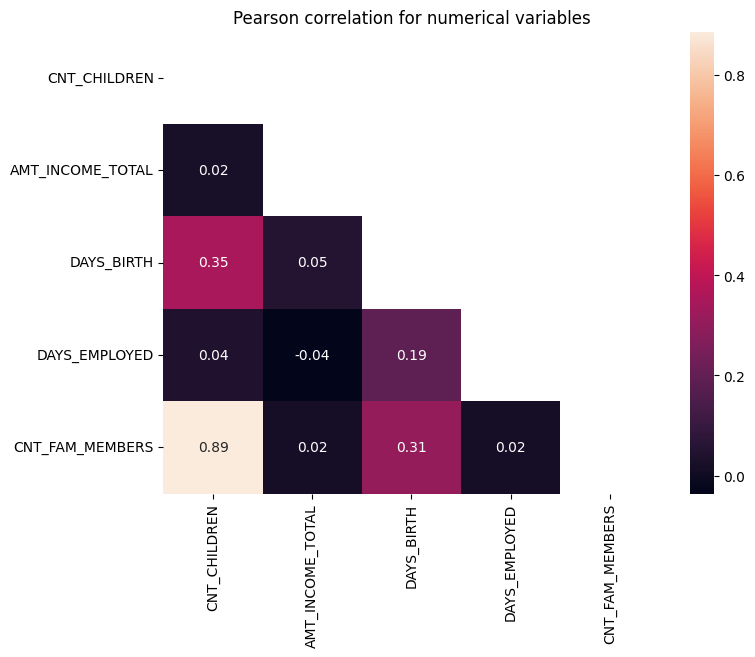

In [58]:
heat_map(df_num, method="num", diagonal=True, figsize=(8,6))

Relation between categorical variables

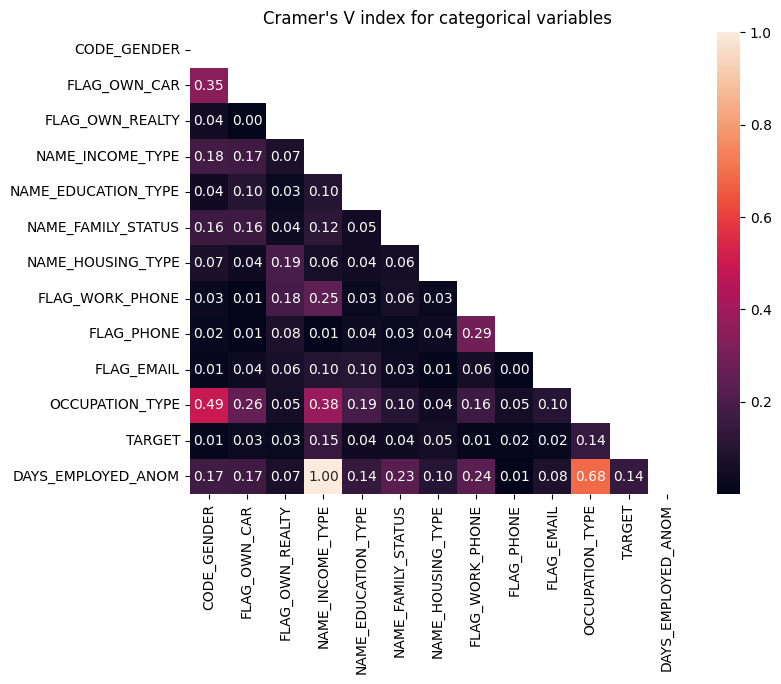

In [59]:
heat_map(df_cat, method="cat", diagonal=True, figsize=(8,6))

Relation between categorical and numerical variables

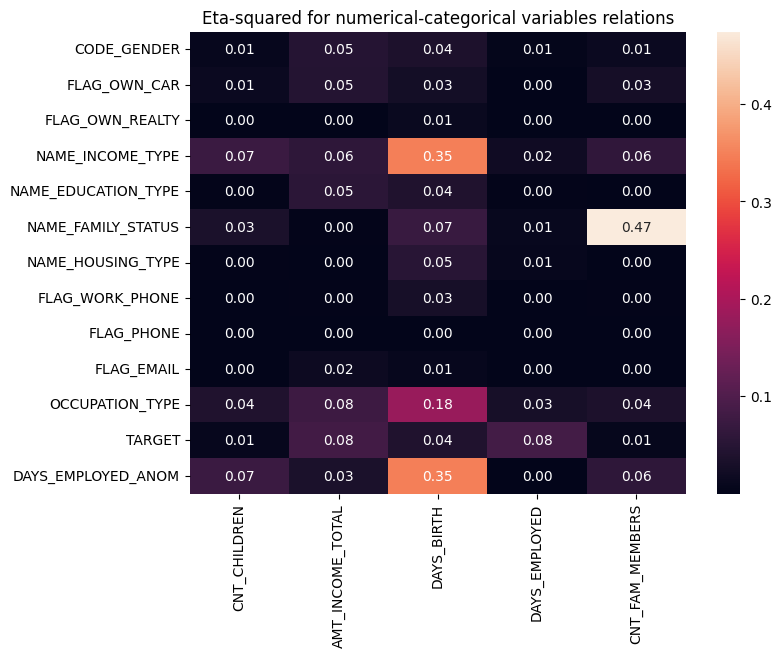

In [60]:
heat_map(df, method="both", figsize=(8,6))

🔔 Correlation insight

From the scatterplot based on the target variable values separation we can assert:
- there isn't any visible correlation between the numerical variables;
- the target's values distribution in each numerical variable seem to have the same shape but for *Response* = 1 there are lower levels. 

From the heatmaps we can see:
- for the numerical variables only a substantial correletion between *CNT_FAM_MEMBERS* and *CNT_CHILDREN* (0.89);
- for the categorical variables the significant associations measured with Cramer's V index are:
    - between *OCCUPATION_TYPE* and *CODE_GENDER* (cramers V index = 0.49, low)
    - between *OCCUPATION_TYPE* and *DAYS_EMPLOYED_ANOM* (cramers V index = 0.68, medium)
    - between *NAME_INCOME_TYPE* and *DAYS_EMPLOYED_ANOM* (cramers V index = 1.00, high)
- for categorical-numerical variables the only medium-high relation could be *CNT_FAM_MEMBERS*-*NAME_FAMILY_STATUS* ($ H^2=0.47 $ not so high)

NB: $ H^2 $ is the proportion of the explained variance calculated from Kruskal-Wallis test (similar to the measure of the $ \eta^2 $ for the ANOVA test)

### Boxplot target variable conditioning

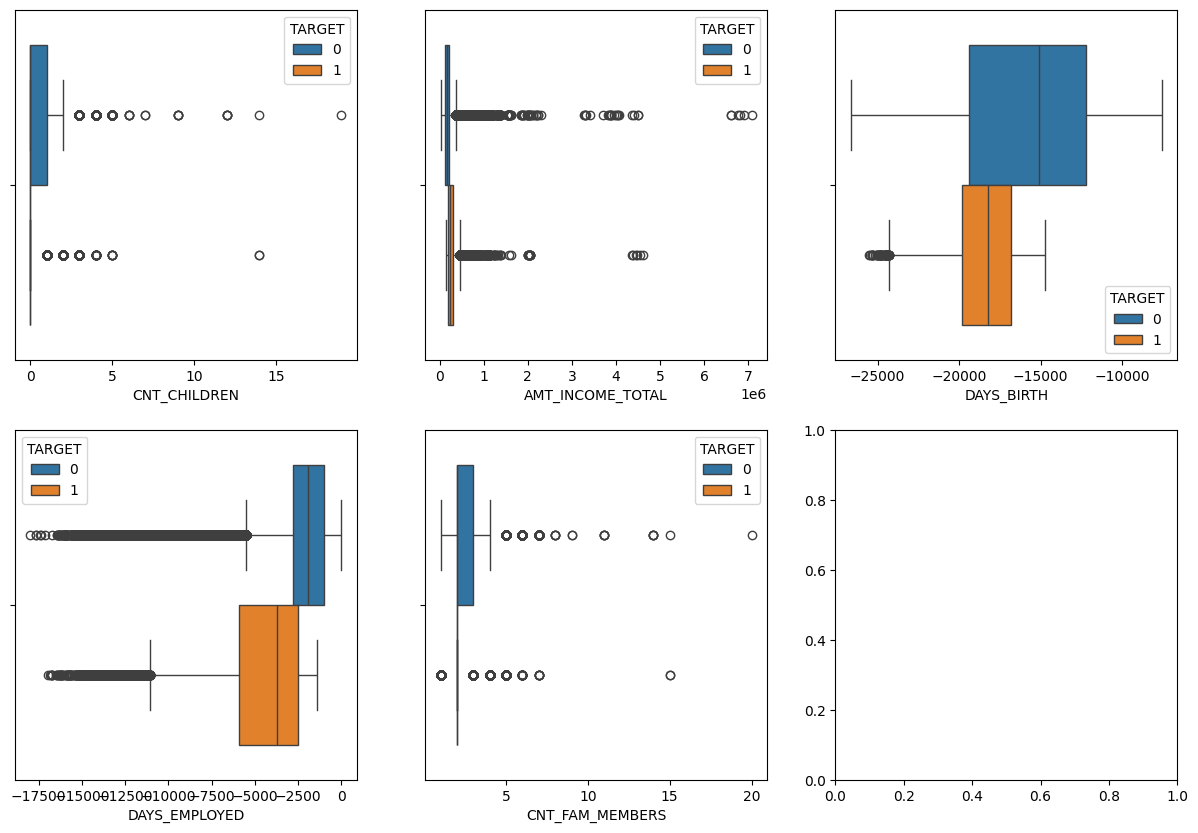

In [61]:
sub_boxplots(df, var=num, hue='TARGET')

🔔 Distribution insight related to target values

From the boxplots we can see in *DAYS_BIRTH* a little difference in the distributions based on target values (1 has the median a little lower).

Even for *DAYS_EMPLOYED* we can see a difference in the distributions based on target values (for value target 1 is shifted at the left), this variable has a lot of outliers for both target values.

### Stacked histogram based on target feature values

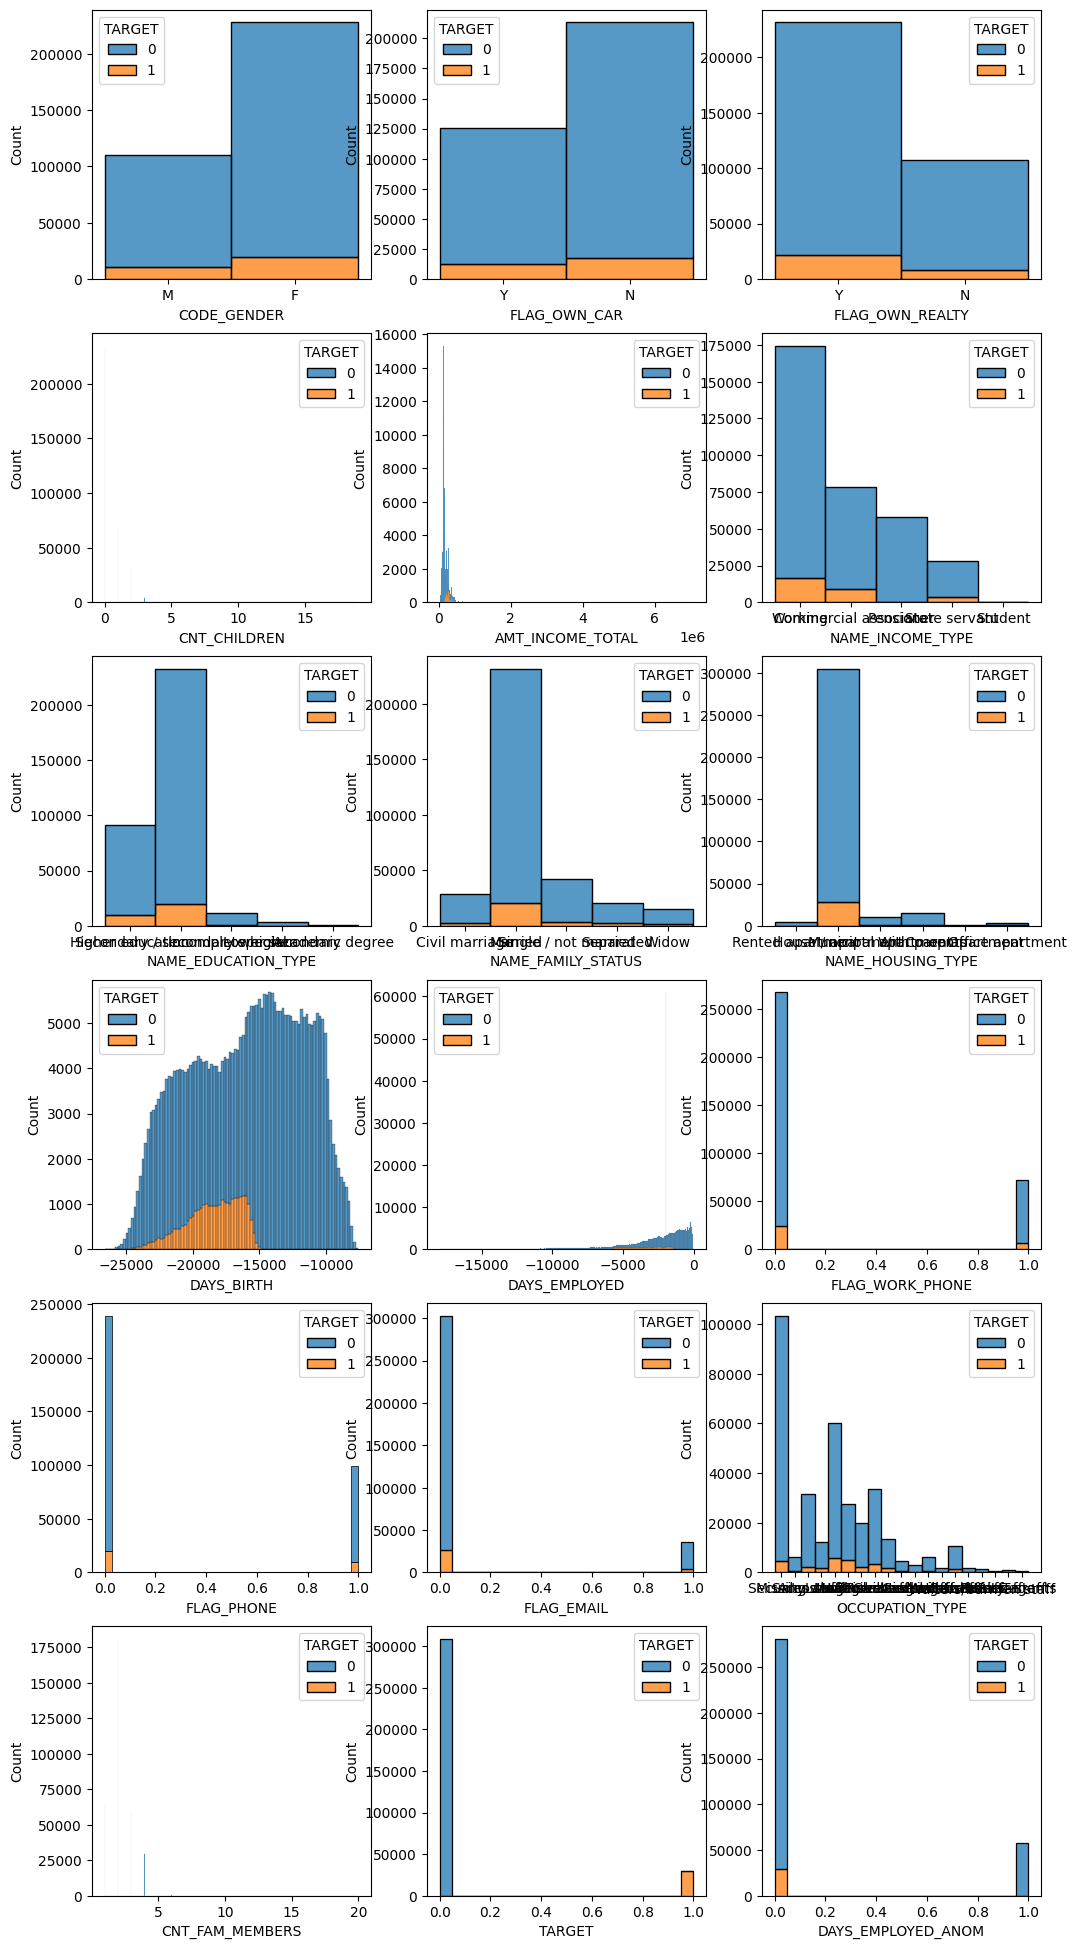

In [62]:
sub_stacked_hist(df, subplot_cols=3, fig_size=(15,20), hue='TARGET')

🔔 There aren't hard visible correlations in the variables divided by the target values in the staked histograms view.

## Hypothesis testing

$H_0$: No correlation ($corr=0$) between the variables *CNT_FAM_MEMBERS* and  *CNT_CHILDREN*

In [63]:
hp_correlations(df['CNT_FAM_MEMBERS'], df['CNT_CHILDREN'], test='num')

P-value: 0.00000 < 0.05, H_0 is rejected. The correlation between 2 variables is significantly different to 0.


(np.float64(0.0), [{'corr_index': np.float64(0.886558917207529)}])

$H_0$: No association (are independent) between the variables *OCCUPATION_TYPE* and *CODE_GENDER*

In [64]:
hp_correlations(df['OCCUPATION_TYPE'], df['CODE_GENDER'], test='chi2')

P-value: 0.00000 < 0.05, H_0 is rejected. The correlation between 2 variables is significantly different to 0.


(np.float64(0.0),
 [{'chi2-stat': np.float64(82526.0090482554)},
  {'freq-tab': CODE_GENDER                F      M
   OCCUPATION_TYPE                    
   Accountants            11938    343
   Cleaning staff          4372    222
   Cooking staff           5617    631
   Core staff             26365   7162
   Drivers                 1259  18761
   HR staff                 536     31
   High skill tech staff   8852   4547
   IT staff                 134    302
   Laborers               26663  33483
   Low-skill Laborers       330   1384
   Managers               15528  11856
   Medicine staff         10207    231
   Missing                80410  22931
   Private service staff   2678    109
   Realty agents            766     86
   Sales staff            27520   4132
   Secretaries             1530     47
   Security staff          2094   4124
   Waiters/barmen staff    1116    129},
  {'expected-freq': array([[ 8270.71240094,  4010.28759906],
          [ 3093.85658903,  1500.14341097

$H_0$: No association (are independent) between the variables *OCCUPATION_TYPE* and *DAYS_EMPLOYED_ANOM*

In [65]:
hp_correlations(df['OCCUPATION_TYPE'], df['DAYS_EMPLOYED_ANOM'], test='chi2')

P-value: 0.00000 < 0.05, H_0 is rejected. The correlation between 2 variables is significantly different to 0.


(np.float64(0.0),
 [{'chi2-stat': np.float64(158703.79901855442)},
  {'freq-tab': DAYS_EMPLOYED_ANOM         0      1
   OCCUPATION_TYPE                    
   Accountants            12281      0
   Cleaning staff          4594      0
   Cooking staff           6248      0
   Core staff             33527      0
   Drivers                20020      0
   HR staff                 567      0
   High skill tech staff  13399      0
   IT staff                 436      0
   Laborers               60146      0
   Low-skill Laborers      1714      0
   Managers               27384      0
   Medicine staff         10438      0
   Missing                45500  57841
   Private service staff   2787      0
   Realty agents            852      0
   Sales staff            31652      0
   Secretaries             1577      0
   Security staff          6218      0
   Waiters/barmen staff    1245      0},
  {'expected-freq': array([[1.01820321e+04, 2.09896793e+03],
          [3.80883115e+03, 7.85168852e+

$H_0$: No association (are independent) between the variables *NAME_INCOME_TYPE* and *DAYS_EMPLOYED_ANOM*

In [66]:
hp_correlations(df['NAME_INCOME_TYPE'], df['DAYS_EMPLOYED_ANOM'], test='chi2')

P-value: 0.00000 < 0.05, H_0 is rejected. The correlation between 2 variables is significantly different to 0.


(np.float64(0.0),
 [{'chi2-stat': np.float64(338426.0)},
  {'freq-tab': DAYS_EMPLOYED_ANOM         0      1
   NAME_INCOME_TYPE                   
   Commercial associate   78090      0
   Pensioner                  0  57841
   State servant          28113      0
   Student                   17      0
   Working               174365      0},
  {'expected-freq': array([[6.47434968e+04, 1.33465032e+04],
          [4.79552900e+04, 9.88570997e+03],
          [2.33081563e+04, 4.80484370e+03],
          [1.40944992e+01, 2.90550076e+00],
          [1.44563962e+05, 2.98010376e+04]])}])

$H_0$: No association (are independent) between the variables *CNT_FAM_MEMBERS* and *NAME_FAMILY_STATUS*

In [67]:
fam_memb_discr = df['CNT_FAM_MEMBERS'].value_counts()
hp_correlations(fam_memb_discr, df['NAME_FAMILY_STATUS'], test='chi2')

P-value: 0.26598 > 0.05, H_0 isn't rejected.


(np.float64(0.26598252861417465),
 [{'chi2-stat': np.float64(34.37777777777779)},
  {'freq-tab': NAME_FAMILY_STATUS  Civil marriage  Married  Separated  Single / not married
   count                                                                       
   1                                0        1          0                     0
   2                                0        0          1                     0
   3                                0        1          0                     0
   4                                0        2          1                     0
   111                              0        0          1                     0
   356                              0        0          0                     1
   3955                             0        0          0                     1
   29236                            0        0          0                     1
   59148                            0        0          0                     1
   64896                  

🔔 Hypothesis testing insight

All the hypothesis tested were confirmed as association/correlation different to 0 exept for the relation between *CNT_FAM_MEMBERS* and *NAME_FAMILY_STATUS* where $H_0$ wasn't rejected.

# Preprocessing

## Missing values

The only feature that shows missing values is *OCCUPATION_TYPE*. Analyzing the nature of the variable the almost 33% of the Nan values dosn't allow us to:
- impute with the mode (most frequent value), because will distort the distribution;
- use a model to predict the possible value of those missing (we lack of hard correlations to use a predictive model for the imputation).

The fact that the variable indicates profession and that there are NaNs that do not correspond to an existing category such as “unemployed” or “student” suggests that those NaNs are not random, but rather due to lack of recorded information or non-applicability.

So the strategy decided to manage those Nans is to create (as already did) a proper category called *Missing* and add a flag feature to record the original Nans *OCCUPATION_TYPE_NAN*

In [68]:
df['OCCUPATION_TYPE_NAN'] = (df['OCCUPATION_TYPE'] == 'Missing').astype(int)

In [69]:
df.isna().sum()

CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
OCCUPATION_TYPE        0
CNT_FAM_MEMBERS        0
TARGET                 0
DAYS_EMPLOYED_ANOM     0
OCCUPATION_TYPE_NAN    0
dtype: int64

## Outliers

The boxplots showed some outliers, so now will be investigated and managed.

In [70]:
for var in num:
    outlier_count = count_outliers(df[var])
    print(f"Counting outlier of {var}: {outlier_count}, {round(outlier_count/len(df), 2)}%")

Counting outlier of CNT_CHILDREN: 4757, 0.01%
Counting outlier of AMT_INCOME_TOTAL: 14027, 0.04%
Counting outlier of DAYS_BIRTH: 0, 0.0%
Counting outlier of DAYS_EMPLOYED: 24323, 0.07%
Counting outlier of CNT_FAM_MEMBERS: 4440, 0.01%


Will be checked the distribution and the values of the variables over a certain percetile

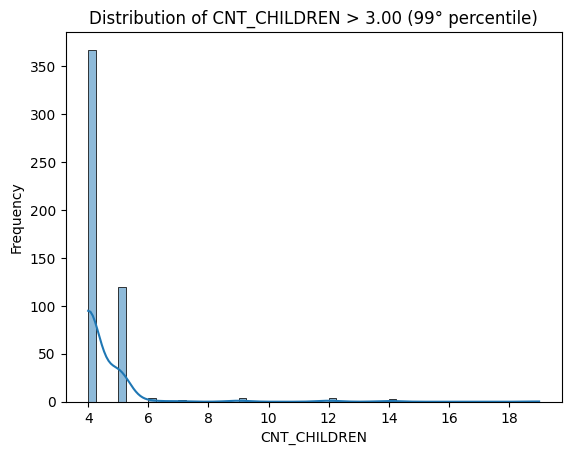

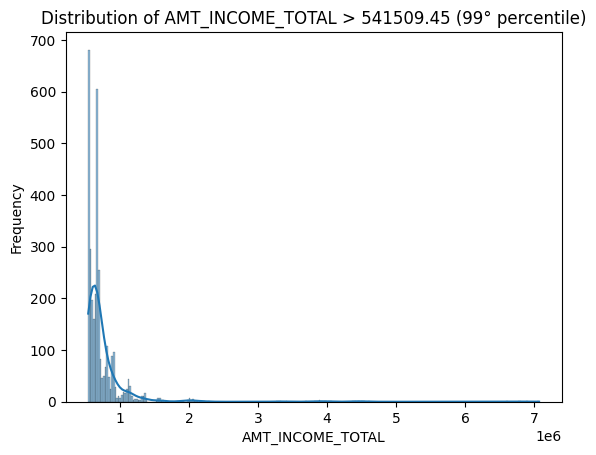

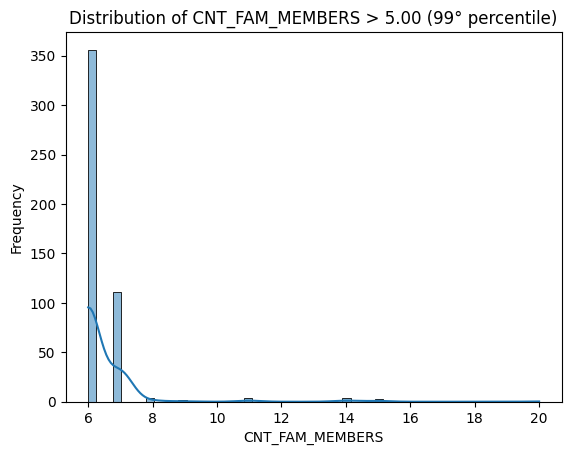

In [71]:
for var in ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS']:
    percentile = 0.99
    threshold = df[var].quantile(percentile)
    filtered = df[df[var] > threshold]
    sns.histplot(filtered[var], kde=True)
    plt.title(f"Distribution of {var} > {threshold:.2f} ({int(percentile * 100)}° percentile)")
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.show()

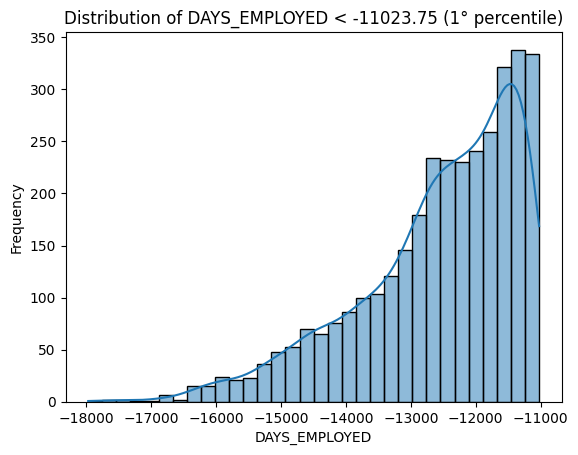

In [72]:
# check the lower bound for days employed
var = 'DAYS_EMPLOYED'
percentile = 0.01
threshold = df[var].quantile(percentile)
filtered = df[df[var] < threshold]
sns.histplot(filtered[var], kde=True)
plt.title(f"Distribution of {var} < {threshold:.2f} ({int(percentile * 100)}° percentile)")
plt.xlabel(var)
plt.ylabel('Frequency')
plt.show()

In [73]:
out_child = df[df['CNT_CHILDREN']>5]
out_child['CNT_CHILDREN'].value_counts()

CNT_CHILDREN
12    4
9     4
6     4
14    3
7     2
19    1
Name: count, dtype: int64

In [74]:
out_memb = df[df['CNT_FAM_MEMBERS']>5]
out_memb['CNT_FAM_MEMBERS'].value_counts()

CNT_FAM_MEMBERS
6.0     356
7.0     111
14.0      4
11.0      4
8.0       4
15.0      3
9.0       2
20.0      1
Name: count, dtype: int64

In [75]:
out_inc = df[df['AMT_INCOME_TOTAL']>1000000]
display(out_inc['AMT_INCOME_TOTAL'].value_counts())
print(out_inc['AMT_INCOME_TOTAL'].value_counts().sum())

AMT_INCOME_TOTAL
1546328.42    1
1345536.06    1
4357128.46    1
4500434.07    1
4533529.12    1
             ..
1355075.02    1
1354357.99    1
1075149.59    1
1129060.25    1
1135164.61    1
Name: count, Length: 322, dtype: int64

322


🔔 Outliers insight

Considering the values of the variables in the extreme percetile we can assert that those are real and rare values, so they won't be imputed. 

## Transformers setting

In [76]:
X = df.drop('TARGET', axis=1)
y = df['TARGET']
num_features, cat_features = variables_type(X)

In [77]:
std_scaler = StandardScaler()
oh_enc = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Classification Model

📊 **Performance metrics considerations**

Generally the accuracy metric for a classification model is a good overall metric to assess the performance, but in the case of an imbalance dataset could be misleading. So we need to take into account other metrics.

The goal for the business case is to predict a customer creditworthness (good = 1, bad = 0) and based on that he will be given a credit card.

In order to choose the right classification metrics we have to give some definitions:
- *False Negative* (for the class 1) are the costumers predicted 0 but they have a good creditworthness (so no credit card release, unsatisfied and angry customer)
- *False Positive* (for the class 1) are the costumers predicted 1 but having a bad creditworthness (so credit card released, loss for the bank that has a credit with a high probability default client).

The best for the bank, from the perspective of minimum loss, is to minimize the *False Positive* rate. so the metric to reach that goal is to look at the highest (maximize) **precision** (for class 1).

Even a minimization of the *False Negative* (look at recall metric) could benefit the bank (in cost of image and customer satisfaction) but would have less direct impact on the economics of the company than the *False Positive*.

To get a trade-off consideration (between recall and precision) we can look at the **F1 score** that balances the two metrics. 

Another important metric that must be considered is the **ROC AUC**. This one is the best one to compare different models (even with different resampling methods) because relies only on False Positives and True Positives in all the possible boundary threshold. 

In [78]:
counter = Counter(y)
target_ratio = counter[1]/len(y)
print(f"Target variable ratio is: \n{1-target_ratio: .2f} for value 0 ({counter[0]} records) \n{target_ratio: .2f} for value 1 ({counter[1]} records)")
print(f"Ratio 1:{counter[0]/counter[1]:.0f}")

Target variable ratio is: 
 0.91 for value 0 (308704 records) 
 0.09 for value 1 (29722 records)
Ratio 1:10


Since we are in the order of hundreds of thousands of examples the cross validation is very computationally expansive so I decided to use the *Hold-Out* method.

Since we have to face the imbalance issue we'll perform a train-test split stratified to preserve the original proportion of the target in the test set.

In [79]:
# stratified train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Models to test (baseline)

- Logistic Regression
- KNN
- Naive Bayes (Gaussian)
- Decision Trees
- Random Forest
- XGBoost
- LightGBM

The SVM algorithm wasn't considered for the following reasons:
- SVM has high computational complexity ( $  O(n^2) $ ) and with so much records the training could be very slow;
- SVM is very subsceptible at class imbalance.

In [80]:
random_seed = 0

In [ ]:
# creating the list for models
List_Classification_Models =[]
List_Classification_Models.append(('LR', LogisticRegression(solver='liblinear', random_state=random_seed), 
                                   std_scaler, oh_enc))
List_Classification_Models.append(('KNN', KNeighborsClassifier(n_neighbors=3,           
                                                                algorithm='kd_tree',
                                                                n_jobs=-1),
                                   std_scaler, oh_enc))
List_Classification_Models.append(('Gauss_NB', GaussianNB(),
                                   std_scaler, oh_enc))
List_Classification_Models.append(('DT', DecisionTreeClassifier(criterion='entropy',
                                                                max_depth=10,
                                                                random_state=random_seed),
                                   'passthrough', oh_enc))
List_Classification_Models.append(('RF', RandomForestClassifier(n_estimators=100, 
                                                                max_depth=10,
                                                                max_features='sqrt',
                                                                n_jobs=-1,
                                                                random_state=random_seed),
                                   'passthrough', oh_enc))
List_Classification_Models.append(('XGB', xgb.XGBClassifier(objective='binary:logistic',
                                                            eval_metric='logloss',
                                                            random_state=random_seed),
                                   'passthrough', oh_enc))
List_Classification_Models.append(('LightGBM', LGBMClassifier(objective='binary',
                                                                learning_rate=0.05,
                                                                n_estimators=300,
                                                                max_depth=7,
                                                                verbosity=-1,
                                                                random_state=random_seed),
                                   'passthrough', ord_enc))

In [82]:
results = []

for name, model, num_trasf, cat_trasf in List_Classification_Models:
    
    if name == 'LightGBM':
        y_pred, y_proba = LigthGBM_predictor(model, num_trasf, cat_trasf, 
                                             X_train, X_test, y_train, y_test,
                                             num_features, cat_features)
    else:
        pipe = make_pipeline(name, model, num_features, cat_features, 
                             num_trasf=num_trasf, cat_trasf=cat_trasf)
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        y_proba = pipe.predict_proba(X_test)[:,1]
    
    result = get_performance_metrics(y_test, y_pred, y_proba, name)
    results.append(result)
    
# converti in DataFrame i risultati
results_df_base = pd.DataFrame(results)
results_df_base = results_df_base.sort_values(by='Precision', ascending=False)

In [83]:
display(results_df_base)

,Feature Selection,Resampling,Model,Accuracy,Precision,Recall,F1 Score,ROC_AUC
5,None,None,XGB,0.956283,0.688423,0.917396,0.786585,0.978268
6,None,None,LightGBM,0.957007,0.688167,0.933378,0.792232,0.978745
3,None,None,DT,0.956357,0.687626,0.921770,0.787665,0.976055
4,None,None,RF,0.920161,0.687240,0.166723,0.268346,0.976769
1,None,None,KNN,0.945838,0.676808,0.733513,0.704021,0.954435
0,None,None,LR,0.913571,0.519715,0.208445,0.297550,0.918405
2,None,None,Gauss_NB,0.339332,0.114634,0.970222,0.205042,0.821315


🔔 Base models insight

Looking at the performance of the base models (no resampling, no tuning, no feature engineering) we are going to evaluate in a deeper analysis all the models except to Logistic Regression and Gaussian Naive Bayes that showed significant lower performances based on our metrics of interest.

## Resampling test

In [84]:
proportions = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
results_df_resampling = pd.DataFrame()
best_models = pd.DataFrame()
metrics = results_df_base.columns[2:]

names = ['KNN', 'DT', 'RF', 'XGB', 'LightGBM']
model_details = [t for t in List_Classification_Models if t[0] in names]

In [85]:
for model_detail in model_details:
    
    name, model, num_trasf, cat_trasf = model_detail
    results =[]
    
    for res_method in ['over', 'under', 'smote']:
        for s in proportions:
            start_time = time.time()
            
            if name == 'LightGBM':
                y_pred, y_proba = LigthGBM_predictor(model, num_trasf, cat_trasf, 
                                                X_train, X_test, y_train, y_test,
                                                num_features, cat_features, 
                                                resampling=res_method,
                                                strategy=s,
                                                random_seed=random_seed)
            
            else:
                pipe = make_pipeline(name, model, num_features, cat_features,
                                     num_trasf=num_trasf, cat_trasf=cat_trasf,
                                     resampling=res_method, strategy=s) 
                pipe.fit(X_train, y_train)
                y_pred = pipe.predict(X_test)
                y_proba = pipe.predict_proba(X_test)[:,1]
            
            end_time = time.time()
            elapsed_time = end_time - start_time
            minutes, seconds = divmod(elapsed_time, 60)

            resample_name = res_method + ' ' + str(s)
            result = get_performance_metrics(y_test, y_pred, y_proba, name, resample_name)
            results.append(result)
            print(f"Finish training {name} {resample_name}  Time: {int(minutes)} min {seconds:.2f} sec")
            
    
    # convert prerfomance measures in DataFrame
    results_df_resampling = pd.concat([results_df_resampling, pd.DataFrame(results)])
    # get best models
    best_models = pd.concat([best_models,
                            get_best_models_by_metrics(metrics, 
                                            results_df_resampling[results_df_resampling['Model']==name])
                            ])

Finish training KNN over 0.2  Time: 1 min 18.01 sec
Finish training KNN over 0.3  Time: 1 min 18.30 sec
Finish training KNN over 0.4  Time: 1 min 23.05 sec
Finish training KNN over 0.5  Time: 1 min 20.91 sec
Finish training KNN over 0.6  Time: 1 min 31.56 sec
Finish training KNN over 0.7  Time: 1 min 23.63 sec
Finish training KNN over 0.8  Time: 1 min 32.83 sec
Finish training KNN over 0.9  Time: 1 min 16.26 sec
Finish training KNN over 1.0  Time: 0 min 52.04 sec
Finish training KNN under 0.2  Time: 0 min 46.59 sec
Finish training KNN under 0.3  Time: 0 min 48.86 sec
Finish training KNN under 0.4  Time: 0 min 55.82 sec
Finish training KNN under 0.5  Time: 0 min 54.39 sec
Finish training KNN under 0.6  Time: 0 min 40.49 sec
Finish training KNN under 0.7  Time: 0 min 40.05 sec
Finish training KNN under 0.8  Time: 0 min 38.63 sec
Finish training KNN under 0.9  Time: 0 min 36.73 sec
Finish training KNN under 1.0  Time: 0 min 58.27 sec
Finish training KNN smote 0.2  Time: 1 min 2.73 sec
Fin

In [86]:
best_models = best_models.drop_duplicates()

## Best Resampling Performance 

In [87]:
for name in names:
    view = results_df_resampling[results_df_resampling['Model']==name]
    display(view)

,Feature Selection,Resampling,Model,Accuracy,Precision,Recall,F1 Score,ROC_AUC
0,None,over 0.2,KNN,0.949738,0.671943,0.835633,0.744901,0.955022
1,None,over 0.3,KNN,0.951053,0.671401,0.866925,0.756737,0.955206
2,None,over 0.4,KNN,0.951497,0.670468,0.880384,0.761219,0.955293
3,None,over 0.5,KNN,0.951585,0.669894,0.884590,0.762416,0.955341
4,None,over 0.6,KNN,0.951497,0.669124,0.885599,0.762291,0.955339
5,None,over 0.7,KNN,0.951585,0.669290,0.886945,0.762897,0.955358
6,None,over 0.8,KNN,0.951585,0.669290,0.886945,0.762897,0.955364
7,None,over 0.9,KNN,0.951570,0.669205,0.886945,0.762842,0.955362
8,None,over 1.0,KNN,0.951570,0.669205,0.886945,0.762842,0.955369
9,None,under 0.2,KNN,0.944080,0.633058,0.864065,0.730739,0.962933


,Feature Selection,Resampling,Model,Accuracy,Precision,Recall,F1 Score,ROC_AUC
0,None,over 0.2,DT,0.955530,0.672669,0.961474,0.791551,0.975151
1,None,over 0.3,DT,0.954112,0.662991,0.971063,0.787986,0.975124
2,None,over 0.4,DT,0.951984,0.650368,0.980148,0.781908,0.974208
3,None,over 0.5,DT,0.952457,0.652393,0.981662,0.783853,0.975173
4,None,over 0.6,DT,0.951482,0.647254,0.983513,0.780716,0.974984
5,None,over 0.7,DT,0.949694,0.638245,0.986036,0.774906,0.974902
6,None,over 0.8,DT,0.949192,0.635537,0.988055,0.773527,0.975379
7,None,over 0.9,DT,0.948704,0.633477,0.986878,0.771639,0.974598
8,None,over 1.0,DT,0.949251,0.636137,0.986205,0.773402,0.974510
9,None,under 0.2,DT,0.955648,0.675077,0.954240,0.790743,0.975249


,Feature Selection,Resampling,Model,Accuracy,Precision,Recall,F1 Score,ROC_AUC
0,None,over 0.2,RF,0.955589,0.680511,0.931696,0.786536,0.977046
1,None,over 0.3,RF,0.955042,0.668291,0.969044,0.791046,0.976748
2,None,over 0.4,RF,0.954141,0.662026,0.976110,0.788958,0.977154
3,None,over 0.5,RF,0.953063,0.655258,0.982335,0.786133,0.977085
4,None,over 0.6,RF,0.951896,0.648705,0.986373,0.782673,0.977319
5,None,over 0.7,RF,0.951275,0.645289,0.988560,0.780864,0.977285
6,None,over 0.8,RF,0.950640,0.642101,0.989401,0.778786,0.977224
7,None,over 0.9,RF,0.949945,0.638732,0.989906,0.776458,0.977129
8,None,over 1.0,RF,0.949665,0.637209,0.991083,0.775693,0.977083
9,None,under 0.2,RF,0.956165,0.679402,0.948351,0.791658,0.977149


,Feature Selection,Resampling,Model,Accuracy,Precision,Recall,F1 Score,ROC_AUC
0,None,over 0.2,XGB,0.956283,0.677025,0.960296,0.794157,0.978405
1,None,over 0.3,XGB,0.955678,0.671362,0.970222,0.793587,0.978380
2,None,over 0.4,XGB,0.954954,0.666322,0.975606,0.791835,0.978422
3,None,over 0.5,XGB,0.954688,0.663373,0.982672,0.792054,0.978468
4,None,over 0.6,XGB,0.954112,0.660194,0.983849,0.790163,0.978663
5,None,over 0.7,XGB,0.954008,0.659242,0.985868,0.790130,0.978679
6,None,over 0.8,XGB,0.953196,0.655015,0.986709,0.787354,0.978104
7,None,over 0.9,XGB,0.952856,0.653234,0.987214,0.786226,0.978370
8,None,over 1.0,XGB,0.952546,0.651845,0.986541,0.785007,0.978589
9,None,under 0.2,XGB,0.956638,0.678068,0.963829,0.796081,0.978535


,Feature Selection,Resampling,Model,Accuracy,Precision,Recall,F1 Score,ROC_AUC
0,None,over 0.2,LightGBM,0.956638,0.677816,0.964838,0.796251,0.978760
1,None,over 0.3,LightGBM,0.955397,0.669017,0.973923,0.793177,0.978348
2,None,over 0.4,LightGBM,0.954304,0.661310,0.983176,0.790745,0.978644
3,None,over 0.5,LightGBM,0.953506,0.656835,0.985363,0.788238,0.978569
4,None,over 0.6,LightGBM,0.952457,0.651276,0.987214,0.784807,0.978600
5,None,over 0.7,LightGBM,0.951984,0.648544,0.989401,0.783507,0.978866
6,None,over 0.8,LightGBM,0.951231,0.644758,0.990242,0.780999,0.978586
7,None,over 0.9,LightGBM,0.950595,0.641612,0.990915,0.778894,0.978733
8,None,over 1.0,LightGBM,0.950329,0.640174,0.991925,0.778144,0.978555
9,None,under 0.2,LightGBM,0.956372,0.676335,0.965007,0.795286,0.978619


In [88]:
best_models

,Feature Selection,Resampling,Model,Accuracy,Precision,Recall,F1 Score,ROC_AUC
0,None,over 0.2,KNN,0.949738,0.671943,0.835633,0.744901,0.955022
24,None,smote 0.8,KNN,0.951940,0.668461,0.898217,0.766492,0.960549
18,None,smote 0.2,KNN,0.949546,0.674969,0.820659,0.740718,0.957124
17,None,under 1.0,KNN,0.860473,0.383193,0.965848,0.548695,0.944335
25,None,smote 0.9,KNN,0.951910,0.667414,0.901750,0.767084,0.961296
9,None,under 0.2,KNN,0.944080,0.633058,0.864065,0.730739,0.962933
0,None,over 0.2,DT,0.955530,0.672669,0.961474,0.791551,0.975151
18,None,smote 0.2,DT,0.956165,0.682392,0.936911,0.789649,0.975864
17,None,under 1.0,DT,0.946798,0.624192,0.990579,0.765819,0.972815
19,None,smote 0.3,DT,0.955294,0.671971,0.959118,0.790269,0.975991


In [89]:
results_df_base

,Feature Selection,Resampling,Model,Accuracy,Precision,Recall,F1 Score,ROC_AUC
5,None,None,XGB,0.956283,0.688423,0.917396,0.786585,0.978268
6,None,None,LightGBM,0.957007,0.688167,0.933378,0.792232,0.978745
3,None,None,DT,0.956357,0.687626,0.921770,0.787665,0.976055
4,None,None,RF,0.920161,0.687240,0.166723,0.268346,0.976769
1,None,None,KNN,0.945838,0.676808,0.733513,0.704021,0.954435
0,None,None,LR,0.913571,0.519715,0.208445,0.297550,0.918405
2,None,None,Gauss_NB,0.339332,0.114634,0.970222,0.205042,0.821315


🔔 Resampling insight

All the models show a decrease in *precision* metric as the dataset is more balanced.

- **KNN**: with the oversampling methods (*RandomOversampling*, *SMOTE*) as much we balance the target classes better performance we get (precision, roc_auc, accuracy), conversely with the undersampling as much we balance the classes the performace decrease (especially accuracy and roc_auc).

- **DT**, **RF**, **XGB**, **LightGBM**: are very stable on the resampling settings changes. The metrics stay in narrow ranges:
    - *roc_auc* on values 97.8-97.2 %
    - *f1* on values 79-72 % 
    - *accuracy* on values 95.7-94 %


🔔 Best performance insight

Looking at the best models performances compared with the base ones we can assert that we can only gain some percentage points on the recall metric, because on the other metrics the resampling methods don't give us better performance especially on the *precision*, *f1* and *roc_auc* scores. Of course there is some improvement but is a minimal amount with high computational cost.


## Class weighted

In [90]:
best_models_cw = pd.DataFrame()
results_df_class_weight = pd.DataFrame()

In [91]:
for model_detail in model_details:
    
    name, model, num_trasf, cat_trasf = model_detail
    results =[]
    
    if name == 'KNN':
        continue
    for prop in proportions:
        
 
        start_time = time.time()
        if name == 'LightGBM':
            y_pred, y_proba = LigthGBM_predictor(model, num_trasf, cat_trasf, 
                                                X_train, X_test, y_train, y_test,
                                                num_features, cat_features,
                                                resampling='cl_weight', strategy=prop)
        else:
            pipe = make_pipeline(name, model, num_features, cat_features, feature_sel=None,
                                 num_trasf=num_trasf, cat_trasf=cat_trasf,
                                 resampling='cl_weight', strategy=prop)
            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_test)
            y_proba = pipe.predict_proba(X_test)[:,1]
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        minutes, seconds = divmod(elapsed_time, 60)

        resample_name = 'class1_w' + ' ' + str(prop)
        result = get_performance_metrics(y_test, y_pred, y_proba, name, resample_name)
        results.append(result)
        print(f"Finish training {name} {resample_name}  Time: {int(minutes)} min {seconds:.2f} sec")
       
            
    # convert prerfomance measures in DataFrame
    results_df_class_weight = pd.concat([results_df_class_weight, pd.DataFrame(results)])
    # get best models
    best_models_cw = pd.concat([best_models_cw,
                            get_best_models_by_metrics(metrics, 
                                            results_df_class_weight[results_df_class_weight['Model']==name])
                            ])


Finish training DT class1_w 0.2  Time: 0 min 7.92 sec
Finish training DT class1_w 0.3  Time: 0 min 7.98 sec
Finish training DT class1_w 0.4  Time: 0 min 7.29 sec
Finish training DT class1_w 0.5  Time: 0 min 7.55 sec
Finish training DT class1_w 0.6  Time: 0 min 7.41 sec
Finish training DT class1_w 0.7  Time: 0 min 7.78 sec
Finish training DT class1_w 0.8  Time: 0 min 7.43 sec
Finish training DT class1_w 0.9  Time: 0 min 7.51 sec
Finish training DT class1_w 1.0  Time: 0 min 7.15 sec
Finish training RF class1_w 0.2  Time: 0 min 16.02 sec
Finish training RF class1_w 0.3  Time: 0 min 16.13 sec
Finish training RF class1_w 0.4  Time: 0 min 17.71 sec
Finish training RF class1_w 0.5  Time: 0 min 17.52 sec
Finish training RF class1_w 0.6  Time: 0 min 18.45 sec
Finish training RF class1_w 0.7  Time: 0 min 18.64 sec
Finish training RF class1_w 0.8  Time: 0 min 17.27 sec
Finish training RF class1_w 0.9  Time: 0 min 22.27 sec
Finish training RF class1_w 1.0  Time: 0 min 17.81 sec
Finish training XGB

In [92]:
best_models_cw = best_models_cw.drop_duplicates()

In [93]:
best_models_cw

,Feature Selection,Resampling,Model,Accuracy,Precision,Recall,F1 Score,ROC_AUC
0,None,class1_w 0.2,DT,0.952161,0.651004,0.981326,0.782743,0.974521
8,None,class1_w 1.0,DT,0.956357,0.687626,0.921770,0.787665,0.976055
4,None,class1_w 0.6,DT,0.955958,0.676264,0.956258,0.792250,0.975910
5,None,class1_w 0.7,DT,0.955899,0.675817,0.956763,0.792116,0.976237
0,None,class1_w 0.2,RF,0.953595,0.658774,0.978297,0.787354,0.977119
3,None,class1_w 0.5,RF,0.956298,0.682876,0.937921,0.790332,0.977176
7,None,class1_w 0.9,RF,0.936383,0.705572,0.472914,0.566277,0.977086
2,None,class1_w 0.4,RF,0.955722,0.674606,0.957773,0.791629,0.977068
0,None,class1_w 0.2,XGB,0.954511,0.662544,0.982335,0.791353,0.978361
4,None,class1_w 0.6,XGB,0.957111,0.682774,0.955585,0.796466,0.978392


In [94]:
results_df_base

,Feature Selection,Resampling,Model,Accuracy,Precision,Recall,F1 Score,ROC_AUC
5,None,None,XGB,0.956283,0.688423,0.917396,0.786585,0.978268
6,None,None,LightGBM,0.957007,0.688167,0.933378,0.792232,0.978745
3,None,None,DT,0.956357,0.687626,0.921770,0.787665,0.976055
4,None,None,RF,0.920161,0.687240,0.166723,0.268346,0.976769
1,None,None,KNN,0.945838,0.676808,0.733513,0.704021,0.954435
0,None,None,LR,0.913571,0.519715,0.208445,0.297550,0.918405
2,None,None,Gauss_NB,0.339332,0.114634,0.970222,0.205042,0.821315


🔔 Class Weighted best performance insight

With this method the training and prediction phases are much faster than the pipeline with resampling.

We can observe significant stability in *roc_auc* (97.4-97.8 %) and *accuracy* (95%) metrics.

Even the *precision* has average values (around 65-68%) with a best of 70% in the **RF 0.9** (but with the lowest *f1-score*).

The *f1-score* has a tight range too (78-79 %).

We can consider as best models of this analysis (high values mainly on precision, roc_auc, accuracy) the *XGB* and *LightGBM* with *class 1 weight 0.6 and 1*.

Even in this scenario the comparison with base models doesn't give us better performance, they are at the end the same in metrics evaluation.

## Feature Selection

### Mutual Information

In [95]:
preprocessor = ColumnTransformer(transformers=[
('num_trasf', std_scaler, num_features),
('cat_trasf', ord_enc, cat_features)
])
# Fit + transform training set
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
# rebuild dataframe with column names
processed_columns = num_features + cat_features
X_train_df = pd.DataFrame(X_train_processed, columns=processed_columns, index=X_train.index)
X_test_df = pd.DataFrame(X_test_processed, columns=processed_columns, index=X_test.index)

mi_scores = mutual_info_classif(X_train_df, y_train, discrete_features='auto')
mi_df = pd.DataFrame({'Feature': X_train_df.columns, 'MI Score': mi_scores})
mi_df = mi_df.sort_values(by='MI Score', ascending=False)

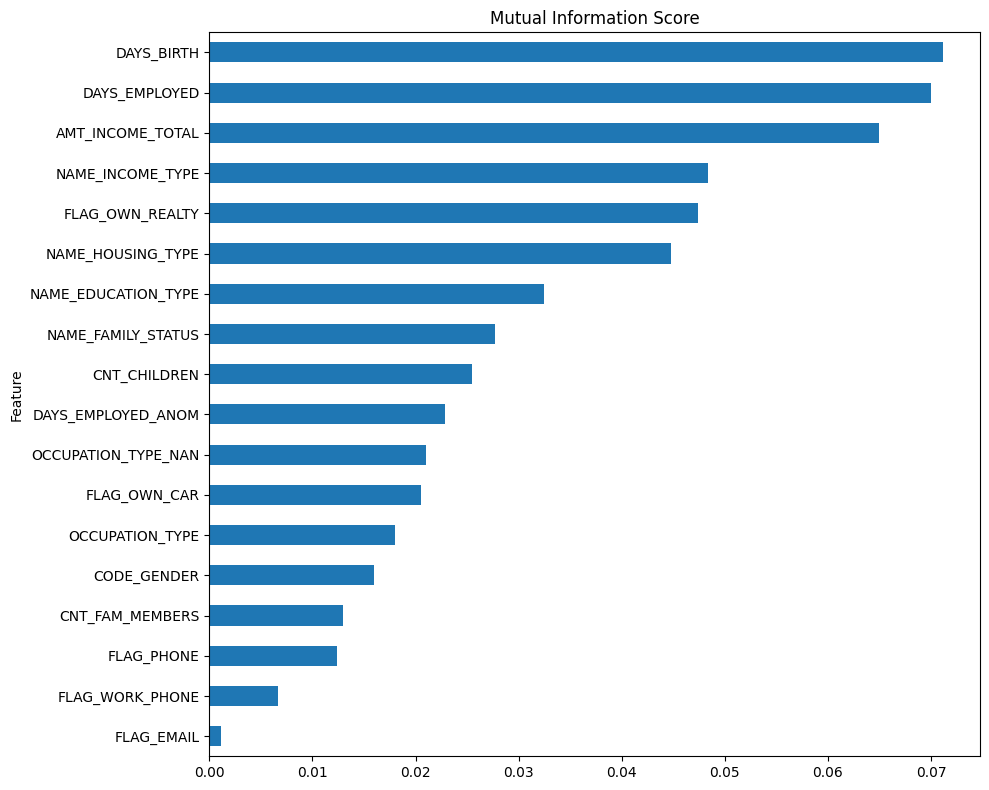

In [96]:
# Plot
plt.figure(figsize=(10, 8))
mi_df.set_index('Feature')['MI Score'].plot(kind="barh")
plt.title("Mutual Information Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Features Importance

In [97]:
# LightGBM
name, lgbm_model, num_trasf, cat_trasf = next((t for t in List_Classification_Models if t[0] == 'LightGBM'), None)
preprocessor = ColumnTransformer(transformers=[
('num_trasf', num_trasf, num_features),
('cat_trasf', cat_trasf, cat_features)
])
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
processed_columns = num_features + cat_features
X_train_df = pd.DataFrame(X_train_processed, columns=processed_columns, index=X_train.index)
X_test_df = pd.DataFrame(X_test_processed, columns=processed_columns, index=X_test.index)
lgbm_model.fit(X_train_df, y_train, categorical_feature=cat_features)

# XGB
name_xgb, xgb_model, num_trasf, cat_trasf = next((t for t in List_Classification_Models if t[0] == 'XGB'), None)
pipe = make_pipeline(name_xgb, xgb_model, num_features, cat_features, 
                     feature_sel=None,
                     num_trasf=num_trasf, cat_trasf=cat_trasf)
pipe.fit(X_train, y_train)
feature_names_xgb = get_feature_names_from_column_transformer(pipe.named_steps['preprocessing'])


In [98]:
# Estrai feature importance
xgb_importance = pd.Series(pipe.named_steps[name_xgb].feature_importances_ ,
                           index=feature_names_xgb, name="XGB")
lgbm_importance = pd.Series(lgbm_model.feature_importances_, index=processed_columns, name="LightGBM")
lgbm_importance_norm = lgbm_importance / lgbm_importance.sum()

print(f"In the XGB base model there are {len(xgb_importance)} features.")
print(f"In the LightGBM base model there are {len(lgbm_importance)} features.")


In the XGB base model there are 48 features.
In the LightGBM base model there are 18 features.


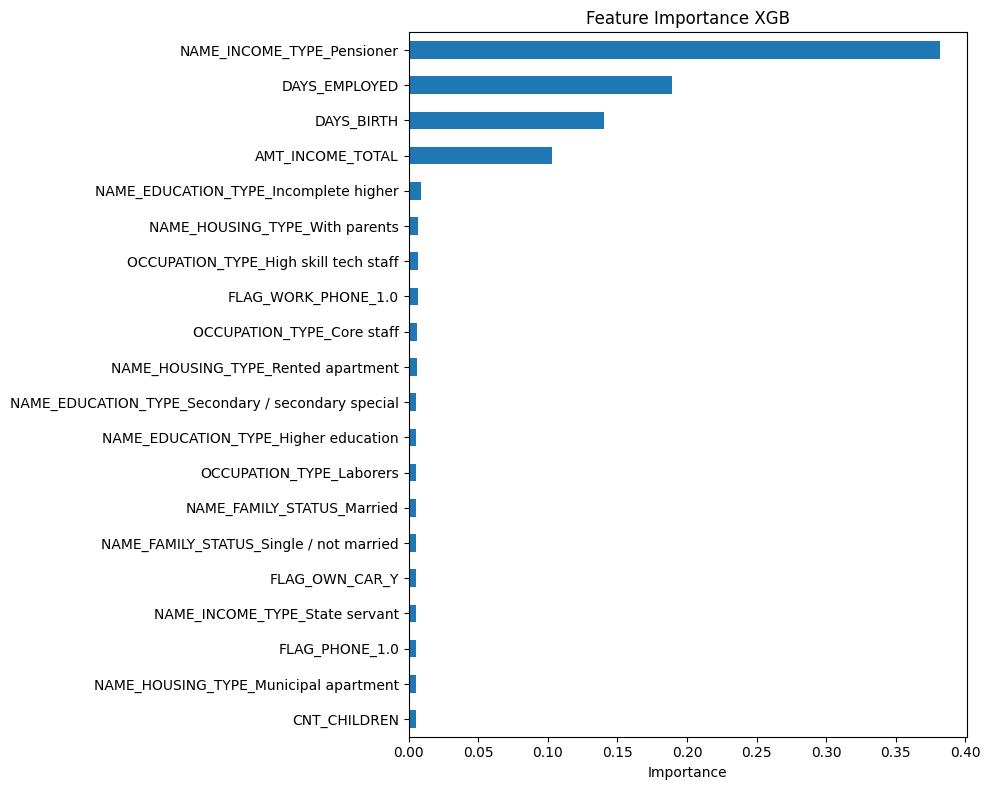

In [99]:
# Plot
plt.figure(figsize=(10, 8))
xgb_importance.sort_values(ascending=False).head(20).plot(kind="barh")
plt.title("Feature Importance XGB")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [100]:
print(f"The first 4 features explain the {xgb_importance.sort_values(ascending=False)[:4].sum()*100:.1f} % of the variance")

The first 4 features explain the 81.5 % of the variance


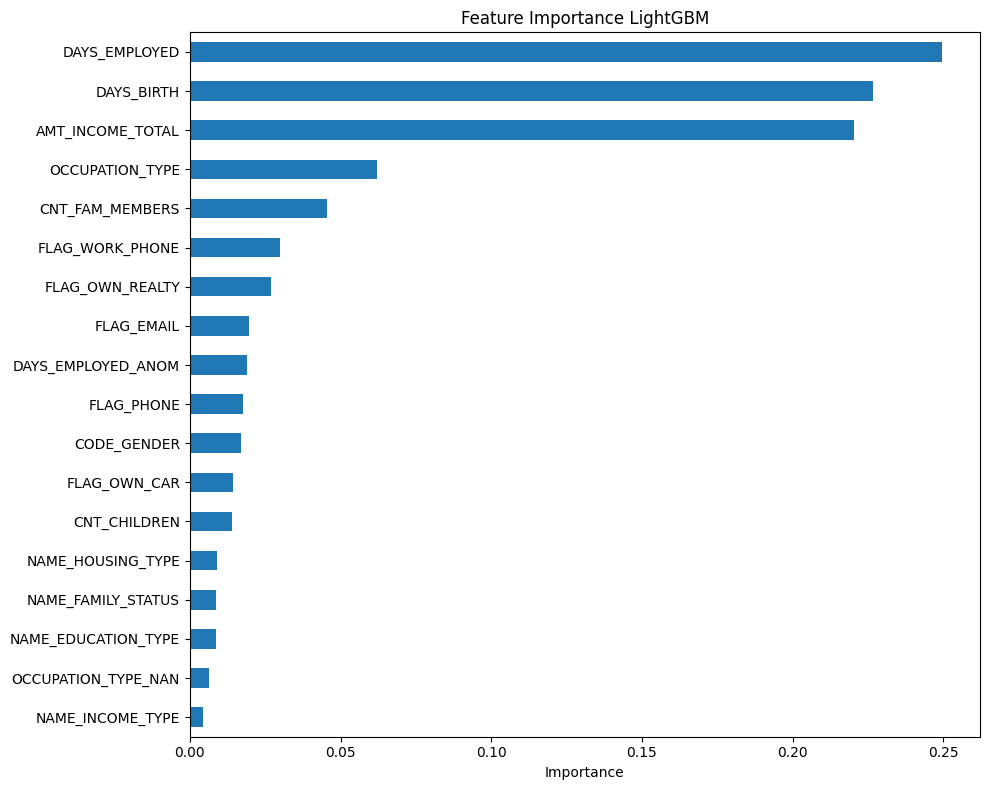

In [101]:
# Plot
plt.figure(figsize=(10, 8))
lgbm_importance_norm.sort_values(ascending=False).head(20).plot(kind="barh")
plt.title("Feature Importance LightGBM")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [102]:
print(f"The first 5 features explain the {lgbm_importance_norm.sort_values(ascending=False)[:5].sum()*100:.1f} % of the variance")

The first 5 features explain the 80.4 % of the variance


<Figure size 1000x800 with 0 Axes>

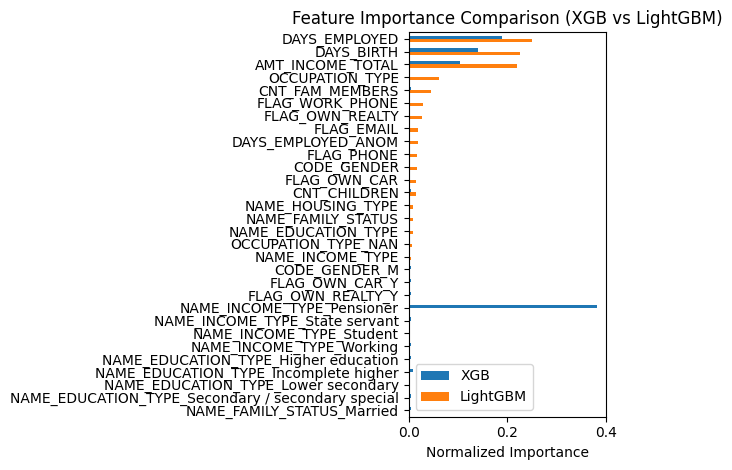

In [103]:
importance_df = pd.concat([xgb_importance, lgbm_importance_norm], axis=1)

# Plot
plt.figure(figsize=(10, 8))
importance_df.sort_values(by="LightGBM", ascending=False).head(30).plot(kind="barh")
plt.title("Feature Importance Comparison (XGB vs LightGBM)")
plt.xlabel("Normalized Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


🔔 Feature Selection insight

From the 3 methods used to evaluate the importance of the features for sure we must consider **DAYS_EMPLOYED**, **DAY_BIRTH**, **AMT_INCOME_TOTAL**.

From XGB and MI we observe that **NAME_INCOME_TYPE** (especially pensioner) has a relatively high importance, so we're going to consider it.

From LightGBM indeed we observed a relative high importance in the **OCCUPATION_TYPE** feature, as so we're going to consider it.

In [104]:
features_selection = ["DAYS_EMPLOYED", "DAYS_BIRTH", "AMT_INCOME_TOTAL", "NAME_INCOME_TYPE", "OCCUPATION_TYPE"]

### Performance with FS

In [105]:
# base models
results = []
for name, model, num_trasf, cat_trasf in List_Classification_Models:
    
    if name == 'LightGBM':
        y_pred, y_proba = LigthGBM_predictor(model, num_trasf, cat_trasf, 
                                             X_train, X_test, y_train, y_test,
                                             num_features, cat_features, 
                                             feature_sel=features_selection)
    else:
        pipe = make_pipeline(name, model, num_features, cat_features, 
                             feature_sel=features_selection,
                             num_trasf=num_trasf, cat_trasf=cat_trasf)
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        y_proba = pipe.predict_proba(X_test)[:,1]
    
    result = get_performance_metrics(y_test, y_pred, y_proba, name, feature_sel=True)
    results.append(result)
    
results_df_sel = pd.DataFrame(results)
results_df_sel = results_df_sel.sort_values(by='Precision', ascending=False)

In [106]:
# models with resampling methods that gave the best metrics
results_df_resampling_sel = pd.DataFrame()
best_models_sel = pd.DataFrame()

names = ['KNN', 'DT', 'RF', 'XGB', 'LightGBM']
model_details = [t for t in List_Classification_Models if t[0] in names]
for model_detail in model_details:
    
    name, model, num_trasf, cat_trasf = model_detail
    resampling_list = get_resampling_method(best_models.loc[best_models['Model']==name])
    results =[]
    
    for res_method, ratio in resampling_list:
        start_time = time.time()
        
        if name == 'LightGBM':
            y_pred, y_proba = LigthGBM_predictor(model, num_trasf, cat_trasf, 
                                            X_train, X_test, y_train, y_test,
                                            num_features, cat_features, 
                                            feature_sel=features_selection,
                                            resampling=res_method,
                                            strategy=ratio,
                                            random_seed=random_seed)
        
        else:
            pipe = make_pipeline(name, model, num_features, cat_features,
                                 feature_sel=features_selection,
                                 num_trasf=num_trasf, cat_trasf=cat_trasf,
                                 resampling=res_method, strategy=ratio) 
            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_test)
            y_proba = pipe.predict_proba(X_test)[:,1]
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        minutes, seconds = divmod(elapsed_time, 60)

        resample_name = res_method + ' ' + str(ratio)
        result = get_performance_metrics(y_test, y_pred, y_proba, name, resample_name, feature_sel=True)
        results.append(result)
        print(f"Finish training {name} {resample_name}  Time: {int(minutes)} min {seconds:.2f} sec")
        
    
    # convert prerfomance measures in DataFrame
    results_df_resampling_sel = pd.concat([results_df_resampling_sel, pd.DataFrame(results)])


Finish training KNN over 0.2  Time: 0 min 15.04 sec
Finish training KNN smote 0.8  Time: 0 min 18.39 sec
Finish training KNN smote 0.2  Time: 0 min 15.84 sec
Finish training KNN under 1.0  Time: 0 min 5.30 sec
Finish training KNN smote 0.9  Time: 0 min 18.24 sec
Finish training KNN under 0.2  Time: 0 min 9.36 sec
Finish training DT over 0.2  Time: 0 min 1.87 sec
Finish training DT smote 0.2  Time: 0 min 2.77 sec
Finish training DT under 1.0  Time: 0 min 0.60 sec
Finish training DT smote 0.3  Time: 0 min 2.90 sec
Finish training RF over 0.2  Time: 0 min 7.97 sec
Finish training RF under 0.2  Time: 0 min 3.82 sec
Finish training RF smote 0.2  Time: 0 min 9.93 sec
Finish training RF over 1.0  Time: 0 min 12.49 sec
Finish training RF under 1.0  Time: 0 min 1.78 sec
Finish training XGB over 0.2  Time: 0 min 1.85 sec
Finish training XGB smote 0.3  Time: 0 min 3.49 sec
Finish training XGB under 1.0  Time: 0 min 0.84 sec
Finish training XGB under 0.2  Time: 0 min 1.18 sec
Finish training XGB o

In [107]:
results_df_sel

,Feature Selection,Resampling,Model,Accuracy,Precision,Recall,F1 Score,ROC_AUC
4,True,None,RF,0.956372,0.689328,0.916050,0.786679,0.978011
5,True,None,XGB,0.956150,0.687500,0.917900,0.786167,0.978225
3,True,None,DT,0.956461,0.687289,0.925135,0.788670,0.976539
6,True,None,LightGBM,0.956712,0.687158,0.930855,0.790654,0.978602
1,True,None,KNN,0.947449,0.682912,0.749664,0.714733,0.956173
0,True,None,LR,0.913320,0.516279,0.205417,0.293898,0.918301
2,True,None,Gauss_NB,0.414325,0.128599,0.981494,0.227402,0.830485


In [108]:
results_df_base

,Feature Selection,Resampling,Model,Accuracy,Precision,Recall,F1 Score,ROC_AUC
5,None,None,XGB,0.956283,0.688423,0.917396,0.786585,0.978268
6,None,None,LightGBM,0.957007,0.688167,0.933378,0.792232,0.978745
3,None,None,DT,0.956357,0.687626,0.921770,0.787665,0.976055
4,None,None,RF,0.920161,0.687240,0.166723,0.268346,0.976769
1,None,None,KNN,0.945838,0.676808,0.733513,0.704021,0.954435
0,None,None,LR,0.913571,0.519715,0.208445,0.297550,0.918405
2,None,None,Gauss_NB,0.339332,0.114634,0.970222,0.205042,0.821315


In [109]:
best_models

,Feature Selection,Resampling,Model,Accuracy,Precision,Recall,F1 Score,ROC_AUC
0,None,over 0.2,KNN,0.949738,0.671943,0.835633,0.744901,0.955022
24,None,smote 0.8,KNN,0.951940,0.668461,0.898217,0.766492,0.960549
18,None,smote 0.2,KNN,0.949546,0.674969,0.820659,0.740718,0.957124
17,None,under 1.0,KNN,0.860473,0.383193,0.965848,0.548695,0.944335
25,None,smote 0.9,KNN,0.951910,0.667414,0.901750,0.767084,0.961296
9,None,under 0.2,KNN,0.944080,0.633058,0.864065,0.730739,0.962933
0,None,over 0.2,DT,0.955530,0.672669,0.961474,0.791551,0.975151
18,None,smote 0.2,DT,0.956165,0.682392,0.936911,0.789649,0.975864
17,None,under 1.0,DT,0.946798,0.624192,0.990579,0.765819,0.972815
19,None,smote 0.3,DT,0.955294,0.671971,0.959118,0.790269,0.975991


In [110]:
results_df_resampling_sel

,Feature Selection,Resampling,Model,Accuracy,Precision,Recall,F1 Score,ROC_AUC
0,True,over 0.2,KNN,0.950832,0.676423,0.843708,0.750861,0.956111
1,True,smote 0.8,KNN,0.952959,0.670497,0.913022,0.773187,0.963481
2,True,smote 0.2,KNN,0.950758,0.677982,0.836642,0.749002,0.958803
3,True,under 1.0,KNN,0.919023,0.520547,0.986709,0.681541,0.966168
4,True,smote 0.9,KNN,0.952989,0.669739,0.916723,0.774006,0.963207
5,True,under 0.2,KNN,0.951039,0.665077,0.891319,0.761754,0.969920
0,True,over 0.2,DT,0.956047,0.676958,0.955417,0.792437,0.974949
1,True,smote 0.2,DT,0.955412,0.677376,0.939939,0.787345,0.974820
2,True,under 1.0,DT,0.947197,0.626387,0.988055,0.766710,0.971255
3,True,smote 0.3,DT,0.955323,0.672129,0.959118,0.790378,0.975620


🔔 Performance with Feature Selection insight

The metrics with feature selection (made this way) aren't so satisfying. We don't get so much better performance compared to the base models, neither with the ("best") resampling methods. We can see that with the resampling the recall metric is the one that improves the most. Without resampling and with feature selection we can see that the tree-based models get good performance on the precison metric.

Only some models obtained a tiny better performance:
- Random Forest (no resampling): **precision = 68.93%**, f1 = 78.66%, roc_auc = 97.80%
- LightGBM (no resampling):      precision = 68.71%, f1 = 79.06%, **roc_auc = 97.86%**
- LightGBM RandomOverSampling 0.2:	precision = 67.58%,	**f1 = 79.38%**, roc_auc = 97.86%
- XGBoost randomUnderSampling 0.2:	precision = 67.40%, **f1 = 79.24%**, roc_auc = 97.84%
- Random Forest SMOTE 0.2:	precision = 67.98%,	**f1 = 79.32%**, roc_auc = 97.71%


## Under / Over fitting

We are going to test the overfitting and underfitting on the best models coming from the all analysis above, that are:
- Random forest
    1. SMOTE 0.2 + feature selection
    2. base + feature selection
    3. class weight 0.9
- XGBoost
    1. base model
    2. undersampling 0.2 + feature selection
    3. class weight 0.6
    4. class weight 1
- LightGBM
    1. base model
    2. SMOTE 0.2
    3. base + feature selection
    4. oversampling 0.2 + feature selection
    5. class weight 0.6
    6. class weight 1
   

In [111]:
# tuple setting => (feature slection, resampling or class_weight)
rf_mod_params = [(features_selection, 'smote 0.2'),(features_selection, None),(None, 'cl_weight 0.9')]
xgb_mod_params = [(None, None),(features_selection, 'under 0.2'),(None, 'cl_weight 0.6'),(None, 'cl_weight 1')]
lightgbm_mod_params = [(None, None),(None, 'smote 0.2'),(features_selection, None),(features_selection, 'over 0.2'),(None, 'cl_weight 0.6'),(None, 'cl_weight 1')]

In [112]:
final_models_performance = pd.DataFrame()
names = ['RF', 'XGB', 'LightGBM']
model_details = [t for t in List_Classification_Models if t[0] in names]

for model_detail in model_details:
    
    
    name, model, num_trasf, cat_trasf = model_detail
    params = get_mod_params(name,rf_mod_params, xgb_mod_params, lightgbm_mod_params)
    results =[]
    
    for feature_sel, resampling in params:
        # base setting
        resample_name = None
        resample_str = 'base'
        fs_str = '/'        
        
        # get the resampling method and ratio
        if resampling:
            res_method, ratio = resampling.split()
            ratio = float(ratio)
            resample_name = res_method + ' ' + str(ratio)
            resample_str = resample_name
        if feature_sel:
            fs_str = 'f.s.'
            
        mod_name = name + ' - ' + fs_str + ' - ' + resample_str
        
        if name == 'LightGBM':
            metrics = LigthGBM_predictor(model, num_trasf, cat_trasf, 
                                            X_train, X_test, y_train, y_test,
                                            num_features, cat_features, 
                                            resampling=res_method,
                                            strategy=ratio,
                                            overfitting_test=True,
                                            random_seed=random_seed,
                                            mod_name=mod_name)
        
        else:
            pipe = make_pipeline(name, model, num_features, cat_features,
                                 feature_sel=feature_sel,
                                 num_trasf=num_trasf, cat_trasf=cat_trasf,
                                 resampling=res_method, strategy=ratio) 
            metrics = evaluate_overfitting_underfitting(pipe, X_train, y_train, X_test, y_test, mod_name)
            
        test_metrics=metrics[1]
        result = get_performance_metrics(y_test, y_pred, y_proba, name, resample_name = resample_name, feature_sel=fs_str, metrics=test_metrics)
        results.append(result)        
    
    # convert prerfomance measures in DataFrame
    final_models_performance = pd.concat([final_models_performance, pd.DataFrame(results)])


RF - f.s. - smote 0.2 evaluation:
	ROC_AUC: Good generalization
	PRECISION: Good generalization
	F1_SCORE: Good generalization
	RECALL: Good generalization
	ACCURACY: Good generalization
RF - f.s. - base evaluation:
	ROC_AUC: Good generalization
	PRECISION: Good generalization
	F1_SCORE: Good generalization
	RECALL: Good generalization
	ACCURACY: Good generalization
RF - / - cl_weight 0.9 evaluation:
	ROC_AUC: Good generalization
	PRECISION: Good generalization
	F1_SCORE: Good generalization
	RECALL: Underfitting
	ACCURACY: Good generalization
XGB - / - base evaluation:
	ROC_AUC: Good generalization
	PRECISION: Good generalization
	F1_SCORE: Good generalization
	RECALL: Good generalization
	ACCURACY: Good generalization
XGB - f.s. - under 0.2 evaluation:
	ROC_AUC: Good generalization
	PRECISION: Good generalization
	F1_SCORE: Good generalization
	RECALL: Good generalization
	ACCURACY: Good generalization
XGB - / - cl_weight 0.6 evaluation:
	ROC_AUC: Good generalization
	PRECISION: Good

In [113]:
final_models_performance

,Feature Selection,Resampling,Model,Accuracy,Precision,Recall,F1 Score,ROC_AUC
0,f.s.,smote 0.2,RF,0.956416,0.679841,0.952052,0.793244,0.977150
1,f.s.,None,RF,0.956416,0.679841,0.952052,0.793244,0.977150
2,/,cl_weight 0.9,RF,0.936383,0.705572,0.472914,0.566277,0.977086
0,/,None,XGB,0.956535,0.686971,0.927826,0.789436,0.978379
1,f.s.,under 0.2,XGB,0.955781,0.673445,0.963829,0.792886,0.978095
2,/,cl_weight 0.6,XGB,0.957111,0.682774,0.955585,0.796466,0.978392
3,/,cl_weight 1.0,XGB,0.956283,0.688423,0.917396,0.786585,0.978268
0,/,None,LightGBM,0.957007,0.688167,0.933378,0.792232,0.978745
1,/,smote 0.2,LightGBM,0.956756,0.684481,0.941622,0.792720,0.978326
2,f.s.,None,LightGBM,0.956756,0.684481,0.941622,0.792720,0.978326


🔔 Over / Under - fitting test insight

The only models that show *overfitting* are *LightGBM* with oversampling (as we could expected) methods and/or with feature selection.
The *Random Forest with class weight 0.9* on the recall metric (less important for us) shows underfitting.
All the others show *good generalization* in every metric.

🔔 CHOICE OF THE MODEL

In the end all the manipolations don't add enough value to the performance so the model choosen is the ***LightGBM base model*** (no feature selection, no resampling, no class_weight)

## Model Explainability

In this section is performed the SHAP values analysis to explain the contribution of the features in the predictions.

In [114]:
model_detail = [t for t in List_Classification_Models if t[0] == 'LightGBM']
name, lgbm_model, num_trasf, cat_trasf = model_detail[0]

In [116]:
preprocessor = ColumnTransformer(transformers=[
    ('num_trasf', num_trasf, num_features),
    ('cat_trasf', cat_trasf, cat_features)
])

# Fit + transform training set
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
# rebuild dataframe with column names
processed_columns = num_features + cat_features
X_train_df = pd.DataFrame(X_train_processed, columns=processed_columns, index=X_train.index)
X_test_df = pd.DataFrame(X_test_processed, columns=processed_columns, index=X_test.index)

c:\Users\Tia\Desktop\ProfessionAI\Progetti\Credit_scoring_project\credit_score_venv\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


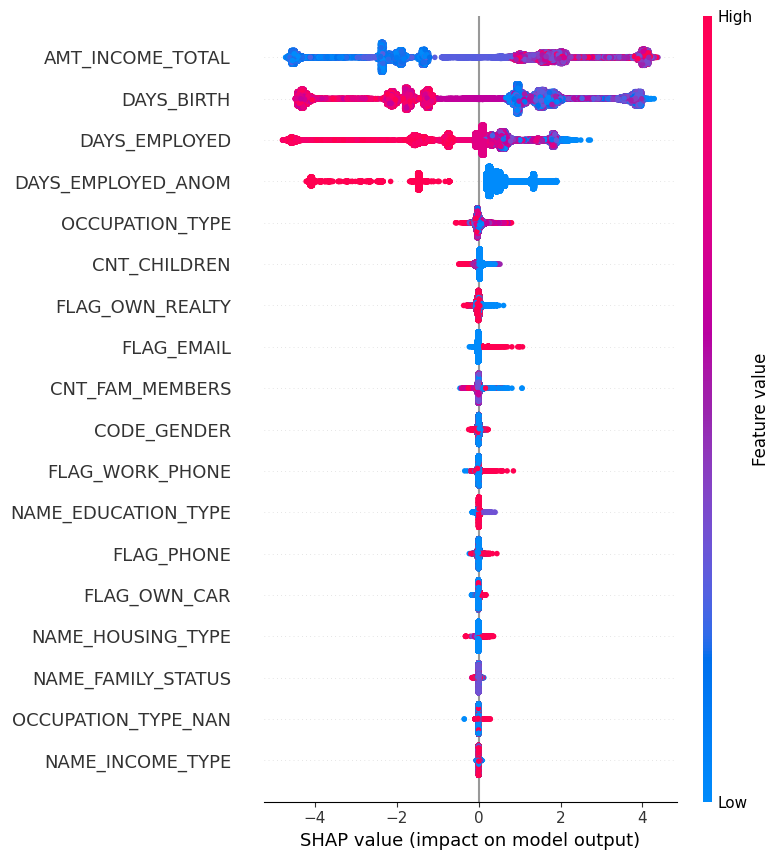

In [117]:
# fit the model
lgbm_model.fit(X_train_df, y_train, categorical_feature=cat_features)

# Create an explainer
explainer = shap.TreeExplainer(lgbm_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_df)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test_df, feature_names=processed_columns)

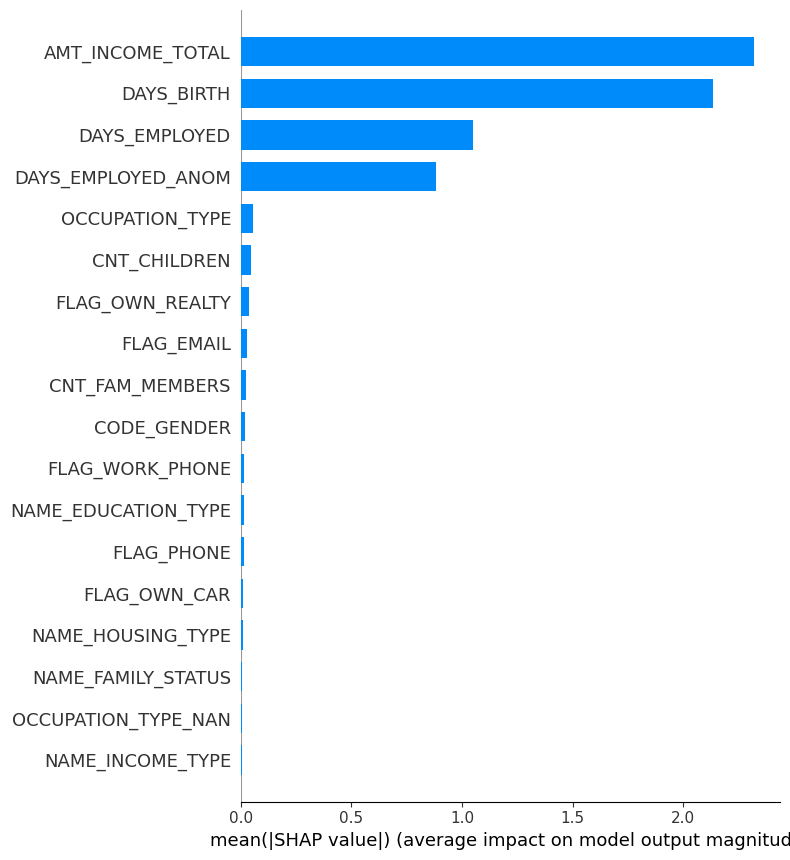

In [ ]:
# Bar chart: mean absolute of SHAP value by feature
shap.summary_plot(
    shap_values, 
    X_test_df, 
    plot_type="bar", 
    feature_names=processed_columns)

🔔 SHAP Summary Plot insight:

- Y axis (Feature)
    1. The variables are sorted based on their absolute mean importance (first up = most important).
    2. *AMT_INCOME_TOTAL*, *DAYS_BIRTH* and *DAYS_EMPLOYED* are the features that contributed the most to the predictions (according to the feature selection analysis).

- X axis (SHAP value)
    1. They represent how much a feature influenced the model on a singular prediction.
    2. Positive values = increase the probability that the model predict the positive class (reliable customer). Negative values = decrease the probability.

- Color = feature value (low-high)
    - Blue: low feature values
    - Red: high feature values 


🧠 Model Explaination

🔹 **AMT_INCOME_TOTAL**: Low values (blue) tend to push the SHAP value towards negative values (so decreasing the probability of a positive prediction). High values (red) push SHAP values towards positive, so higher income equal more reliability.

🔹 **DAYS_BIRTH**, **DAYS_EMPLOYED**: The values of these feature are all negative (because is calculated as difference from today and the birth day, first day of job), so the considerations about the feature value and the correspondent color are opposite.

- DAYS_BIRTH: number of the days from the birth so the lower the value (blue) is the older the person is. Older people (blue values) tend to have positive SHAP values meaning a oder age associated with better reliability.
- DAYS_EMPLOYED: number of the days fromthe first job's day so lower (more negative = blue) the value more employed time. Higher the employing time (blue) tend to have positive SHAP values meaning a person who has been working for a long time is considered more reliable. 


🔹 **DAYS_EMPLOYED_ANOM**: This feature is an indicator of an anomaly (boolean) in the DAYS_EMPLOYED feature (ex. unemployed, missing values, values coded with too big values). About this feature true values produce negative SHAP values (so decrease the probability to predict the positive target class), probably because anomaly means low reliability. 

I create an instance as an example to use the waterfall plot to explain the contribution of every feature in the prediction.

The values set in the instance are based on the summary plot analysis, and the goal is to predict a 0 value so we can explain why a costumer has been rejected from the credit card issuance.

The values assigned are:


AMT_INCOME_TOTAL → low

DAYS_BIRTH → very young (low age)

DAYS_EMPLOYED → very low, or null

DAYS_EMPLOYED_ANOM → set Yes so 1

OCCUPATION_TYPE → lower reliable categories or with very low frequency

CNT_CHILDREN → high

FLAG_EMAIL, FLAG_WORK_PHONE, FLAG_PHONE → all 0 (lack of contacts)

NAME_EDUCATION_TYPE → low level of education

NAME_INCOME_TYPE, NAME_FAMILY_STATUS, ecc. → classes most at risk

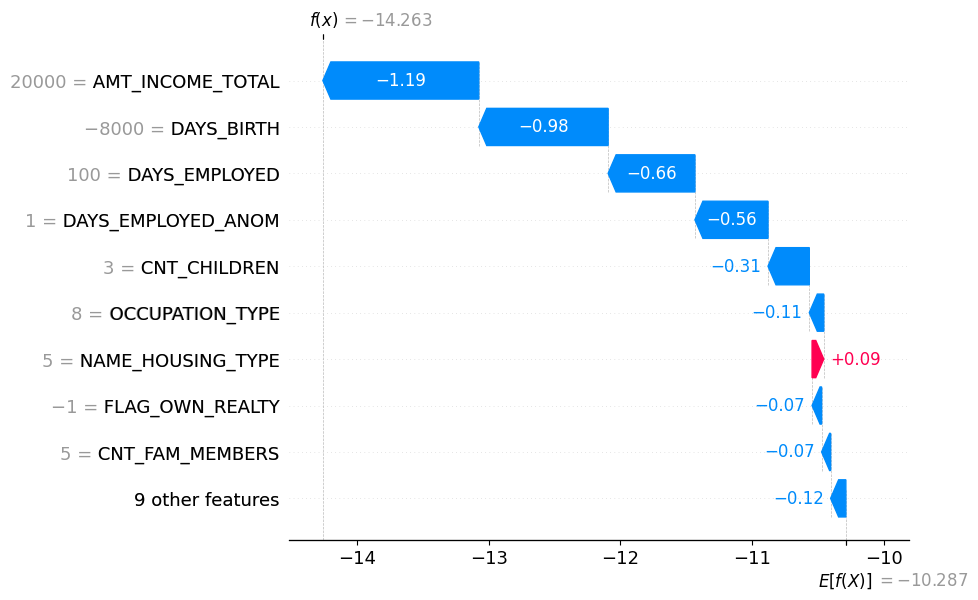

In [ ]:
unfavorable_instance = X_train.iloc[[0]].copy()

unfavorable_instance.loc[:, 'AMT_INCOME_TOTAL'] = 20000      # income very low
unfavorable_instance.loc[:, 'DAYS_BIRTH'] = -8000            # very young (~22 years old)
unfavorable_instance.loc[:, 'DAYS_EMPLOYED'] = 100           # worked very little
unfavorable_instance.loc[:, 'DAYS_EMPLOYED_ANOM'] = 1        # set true anomaly
unfavorable_instance.loc[:, 'OCCUPATION_TYPE'] = 'Laborers'  # category with less worranties
unfavorable_instance.loc[:, 'CNT_CHILDREN'] = 3              # high number of children to care
unfavorable_instance.loc[:, 'CNT_FAM_MEMBERS'] = 5           # high number of family members
unfavorable_instance.loc[:, 'FLAG_OWN_REALTY'] = 0
unfavorable_instance.loc[:, 'FLAG_EMAIL'] = 0
unfavorable_instance.loc[:, 'CODE_GENDER'] = 'M'
unfavorable_instance.loc[:, 'FLAG_WORK_PHONE'] = 0
unfavorable_instance.loc[:, 'NAME_EDUCATION_TYPE'] = 'Lower secondary'
unfavorable_instance.loc[:, 'FLAG_PHONE'] = 0
unfavorable_instance.loc[:, 'FLAG_OWN_CAR'] = 0
unfavorable_instance.loc[:, 'NAME_HOUSING_TYPE'] = 'With parents'
unfavorable_instance.loc[:, 'NAME_FAMILY_STATUS'] = 'Single / not married'
unfavorable_instance.loc[:, 'OCCUPATION_TYPE_NAN'] = 0
unfavorable_instance.loc[:, 'NAME_INCOME_TYPE'] = 'Unemployed'


unfavorable_processed = preprocessor.transform(unfavorable_instance)
unfavorable_df = pd.DataFrame(unfavorable_processed, columns=processed_columns, index=['use_case_unfavorable'])

shap_values_instance = explainer(unfavorable_df)
shap.plots.waterfall(shap_values_instance[0])  

🔍 What is the graph showing?

The expected value of the model is $E[f(X)] \simeq –10.29$.

The output for the example instance is $f(x) \simeq -14.26$.

The model predicted a value far lower of the mean, so this instance has high probability of being classified as 0 (not reliable creditor).


🧩 Interpretation of the single feauteres contribution:
- AMT_INCOME_TOTAL 20,000 -1.19 Very low income → strong negative impact.
- DAYS_BIRTH -8000 (≈ 22 years old) -0.98 Very young age → associated with higher risk.
- DAYS_EMPLOYED 100 -0.66 Worked very little → distrust of the model.
- DAYS_EMPLOYED_ANOM 1 -0.56 Active anomaly indicator → net penalty.
- CNT_CHILDREN 3 -0.31 Many dependent children → increases perceived risk.
- OCCUPATION_TYPE Laborers -0.11 Employment less stable → slight negative impact.
- NAME_HOUSING_TYPE With parents +0.09 Small positive contribution (perhaps less spending).
- FLAG_OWN_REALTY 0 -0.07 Does not own property → slight penalty.
- CNT_FAM_MEMBERS 5 -0.07 Large family → slight negative impact.
- Other 9 miscellaneous attributes -0.12 (total) Small overall negative contributions.

All the negative contributes summed up take the final output value to –14.26, way down the mean threshold. The model has strong motivations to reject the instance.

# Conclusions

Throughout the project, several classification models were evaluated to address a highly imbalanced target variable, with the primary goal of maximizing precison to reduce false positive and identify as many potentially not reliable creditors.

### 1. Evaluated Models
The initial models considered include:
- Logistic Regression (LR)
- K-Nearest Neighbors (KNN)
- Gaussian Naive Bayes (GaussianNB)
- Decision Tree (DT)
- Random Forest (RF)
- XGBoost (XGB)
- LightGBM

### 2. Applied Approaches
Each model was tested under different configurations:
- Baseline: preprocessing (adapted on the model) + model without addressing class imbalance.
- Resampling: application of resampling techniques (GuassianNB, LR not analyzed due to poor performance):
    - Random Oversampling
    - Random Undersampling
    - SMOTE
    - Class Weights: gave comparable results than resampling (with the advantage that the data are not modified).

For all the methods are choosen the best models for every metric.

### 5. Feature Selection
Feature selection was tested in two different configurations. Wes analyzed the Mutual Information and the Feature Importance with LightGBM and XGBoost models. The results were according by the different methods and was created a subset of features to perform feature selection. 

Only few models get better performance than baseline models.

### 4. Overfitting and Underfitting
Top models were evaluated for overfitting and underfitting using multiple metrics. 

Based on the previous analysis the model choosen was ***LightGBM base model*** 

### 5. Explainability of the Model
The SHAP value method was used to evaluate the contribution of the features to the prediction.

- Summary plot: to evaluate the mean contribution.
- Waterfall plot: to evaluate the contributions on a single instance (explain why a customer is rejected from the credit card issuance).